In [1]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [2]:
"""
Michael Pham
April 28

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

version 5 with K, Z, H, Hc, L (solved endogenously) state variable
this version now has heterogeneity in human capital levels and misperception
no consumption tax
"""

'\nMichael Pham\nFebruary 2025\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nversion 4 with K, Z, H, L (solved endogenously) state variable\nno consumption tax\n'

In [3]:
exp = np.e
log = math.log

In [4]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 2  # disutility from working
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
phi_p = 0.324  # share of parental input in education
psi_e = 0.29  # CES parameter for education inputs
theta_I = 0.5  # human capital investment effectiveness
varsigma_g = 1
varsigma_p = 1


# phi_p = 0.324
# varsigma_p = 1
# varsigma_g = 1
# theta_I = 0.5
# psi_e = 0.29
# I_e = (0.06 * Y)
# I_e_mean = (0.035*Y)
# e_mean = 0.01
# e_min = 0.001
# e_max = 1





tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.06 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 50  # number of points in capital grid
nh = 50   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# hmin = 0
# hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 2
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K


# h_min, h_max = 1, 1500
h_min, h_max = 1, 10


# Number of periods
periods = 40
child_periods = 16

In [5]:
l_init = 0.2
r_init = beta**(-1) - 1

Production Equations

In [6]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Human Capital Equations

In [7]:
def human_capital_formation(h_c, e_p, I_e, e_mean, I_e_mean):
    """

    params: 
    returns: 
    """

    I_c = (phi_p * (varsigma_p * (e_p / e_mean)) ** psi_e + (1-phi_p) * (varsigma_g * I_e/I_e_mean) ** psi_e ) ** (1/psi_e)
    
    return (I_c ** theta_I) * (h_c ** (1-theta_I))

Government Equations

In [8]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [9]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


# def next_value_function(k):
#   return vr_polate(k)

def labor_foc(k, k_prev, h, w, r, tau, T):

  l = (1/(1+gamma)) * ( 1 - (gamma * (((1+r) * k_prev - tau * r * k_prev + T - k))/((1-tau)*w*h)))

  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  return l


def value_function(next_value_interpolator, k, k_prev, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)


  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k)

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


In [10]:
h_init = 2
l_init = 0.3

#initialize steady state variable predictions
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
Z_bar = 0.1
K_bar = ((r_init + delta)/((alpha-psi)*tfp*(Z_bar**psi)))**(1/(alpha-psi-1)) * (H_bar * L_bar) #new guess!
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

# h = 3
l = 0.2

K_bar

0.6612600167995938

In [11]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

In [12]:
def loggrid(xmin, xmax, n, degree) :
    """
    Create a grid with logarithmically spaced points between xmin and xmax.
    
    Args:
        xmin: Minimum value of the grid
        xmax: Maximum value of the grid
        n: Number of points in the grid
        degree: Parameter controlling the spacing density (default=1.0)
    
    Returns:
        np.ndarray: Array of logarithmically spaced points
    """

    # Create evenly spaced points between 0 and 1
    points = np.linspace(0, 1, n)
    
    # Transform to logarithmic spacing and apply degree
    # Handle the case where xmin is zero to avoid division by zero
    if xmin == 0:
        # Use linear spacing if xmin is zero
        grid = xmin + (xmax - xmin) * (points**degree)
    else:
        grid = xmin * (xmax/xmin)**(points**degree)

    return grid
    

In [13]:
def spbas(r: int, knots: np.ndarray) -> np.ndarray:
    """
    Evaluate basis function of cubic spline on r+2 knots.
    
    Args:
        r: Integer number of internal knots
        knots: Array of knot positions of length r+2
        
    Returns:
        invT: Inverse of the tridiagonal matrix T
    """
    # Calculate distances between consecutive knots
    dt = knots[1:] - knots[:-1]  # equivalent to dt(i) = knots(i+1)-knots(i)
    
    # Calculate special end conditions
    w1 = dt[1] - (dt[0]**2 / dt[1])
    wr = dt[r-1] - (dt[r]**2 / dt[r-1])
    
    # Initialize tridiagonal matrix T
    T = np.zeros((r, r))
    
    # Fill interior points of tridiagonal matrix
    for i in range(1, r-1):  # equivalent to do i = 2,r-1
        T[i, i-1] = dt[i+1]      # subdiagonal
        T[i, i] = 2.0 * (dt[i] + dt[i+1])  # diagonal
        T[i, i+1] = dt[i]        # superdiagonal
    
    # Set knot-a-knot condition entries
    T[0, 0] = 2.0 * (dt[0] + dt[1]) - w1
    T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
    T[r-1, r-1] = 2.0 * (dt[r-1] + dt[r]) - wr
    T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])
    
    # Return inverse of T
    return np.linalg.inv(T)

iter: 0; K change: 151.23; H change: 50.00; L change: 6.67; Z change: 1000.00
y: 0.5397986988643104
ie: 0.032387921931858625
tax_revenue: 0.05485694361172334
grants: 0.03778590892050173
T: 0.027867008668507817
iter: 0; K: 0.66; H: 2.00; L: 0.30; Z: 0.10
iter: 0; Y: 0.54; tau: 0.15; T: 0.03


/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_18485/3499442841.py:16: RuntimeWarning: invalid value encountered in scalar divide
  w1 = dt[1] - (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_18485/3499442841.py:17: RuntimeWarning: invalid value encountered in scalar divide
  wr = dt[r-1] - (dt[r]**2 / dt[r-1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_18485/3499442841.py:30: RuntimeWarning: invalid value encountered in scalar divide
  T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_18485/3499442841.py:32: RuntimeWarning: invalid value encountered in scalar divide
  T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])



Full output of k1_optimal_array[0]:
[[0.00387513 0.00383105 0.00378495 0.00373676 0.00368642 0.00363385
  0.00357898 0.00352173 0.00346203 0.0033998  0.00333496 0.00326744
  0.00319716 0.00312404 0.00304801 0.00296899 0.00288691 0.00280168
  0.00271323 0.0026215  0.00252641 0.00242789 0.00232586 0.00222027
  0.00211104 0.00199812 0.00188144 0.00176094 0.00163657 0.00150827
  0.001376   0.0012397  0.00109934 0.00095486 0.00080625 0.00065346
  0.00049646 0.00033524 0.00016975 0.        ]
 [0.00387572 0.00383163 0.00378551 0.00373733 0.00368698 0.0036344
  0.00357952 0.00352226 0.00346255 0.00340031 0.00333547 0.00326793
  0.00319764 0.00312451 0.00304847 0.00296944 0.00288734 0.0028021
  0.00271364 0.0026219  0.0025268  0.00242826 0.00232621 0.0022206
  0.00211136 0.00199842 0.00188172 0.0017612  0.00163681 0.00150849
  0.0013762  0.00123989 0.0010995  0.000955   0.00080637 0.00065356
  0.00049654 0.00033528 0.00016978 0.        ]
 [0.00387843 0.00383431 0.00378816 0.00373994 0.00368956

/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_18485/2485930787.py:303: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_gen[q+1] = float(bi_polate(np.array([[k_gen[q], h]]))) #right index?


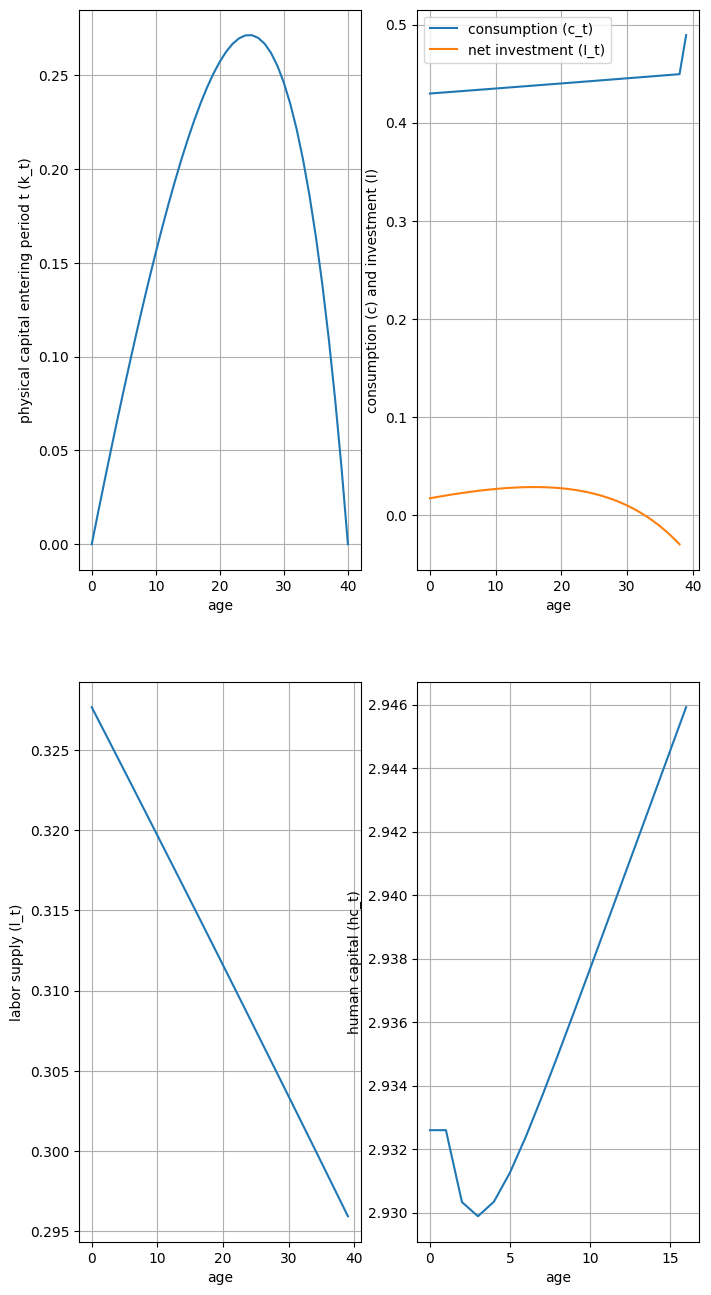

iter: 1; K change: 0.17; H change: 0.09; L change: 0.01; Z change: 0.11
y: 0.5572487952713117
ie: 0.0334349277162787
tax_revenue: 0.05839333173232582
grants: 0.03900741566899182
T: 0.030530891968760222
iter: 1; K: 0.57; H: 2.19; L: 0.30; Z: 0.11
iter: 1; Y: 0.56; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02131355 0.02116846 0.02101294 0.0208464  0.02066817 0.02047752
  0.02027375 0.02005611 0.01982382 0.01957603 0.01931189 0.01903049
  0.01873092 0.01841223 0.01807343 0.01771358 0.01733166 0.01692667
  0.01649755 0.01604319 0.01556252 0.01505446 0.0145179  0.01395174
  0.01335486 0.01272618 0.01206456 0.01136893 0.01063822 0.00987135
  0.00906729 0.00822502 0.00734355 0.00642191 0.00545919 0.00445449
  0.00340701 0.00231592 0.00118048 0.        ]
 [0.02131669 0.02117158 0.02101604 0.02084948 0.02067121 0.02048054
  0.02027675 0.02005907 0.01982674 0.01957892 0.01931474 0.0190333
  0.01873369 0.01841494 0.0180761  0.01771619 0.01733422 0.01692917
  0.01649999 0.0160455

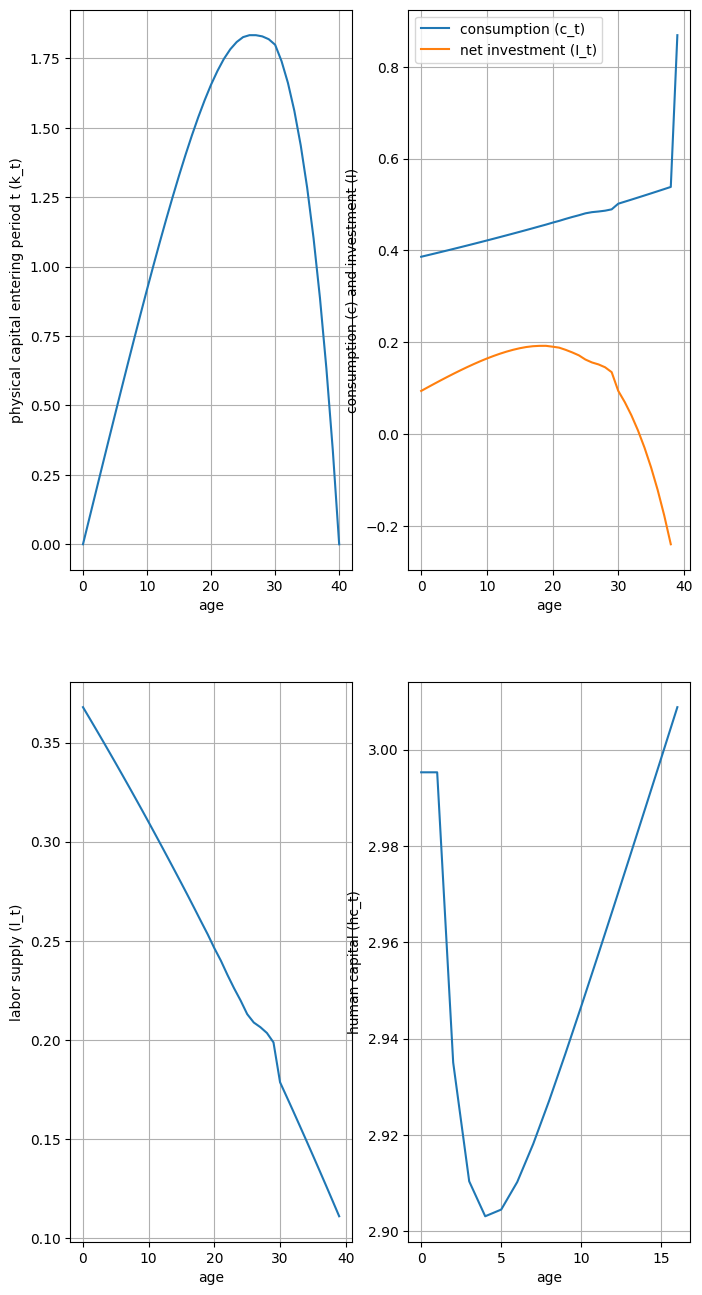

iter: 2; K change: 0.18; H change: 0.07; L change: 0.04; Z change: 0.10
y: 0.6018524236363513
ie: 0.03611114541818108
tax_revenue: 0.06183267750698228
grants: 0.042129669654544594
T: 0.031740056325164724
iter: 2; K: 0.69; H: 2.35; L: 0.29; Z: 0.12
iter: 2; Y: 0.60; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.01067148 0.01056727 0.01045748 0.01034188 0.01022021 0.01009221
  0.00995764 0.00981622 0.00966768 0.00951174 0.00934813 0.00917657
  0.00899677 0.00880843 0.00861128 0.00840501 0.00818932 0.00796395
  0.00772857 0.0074829  0.00722665 0.00695953 0.00668126 0.00639156
  0.00609015 0.00577675 0.00545111 0.00511297 0.00476208 0.0043982
  0.00402109 0.00363055 0.00322636 0.00280832 0.00237626 0.00193
  0.00146938 0.00099425 0.0005045  0.        ]
 [0.01067305 0.01056883 0.01045903 0.01034341 0.01022172 0.01009371
  0.00995911 0.00981767 0.0096691  0.00951315 0.00934952 0.00917793
  0.0089981  0.00880973 0.00861255 0.00840625 0.00819054 0.00796512
  0.00772971 0.00748401

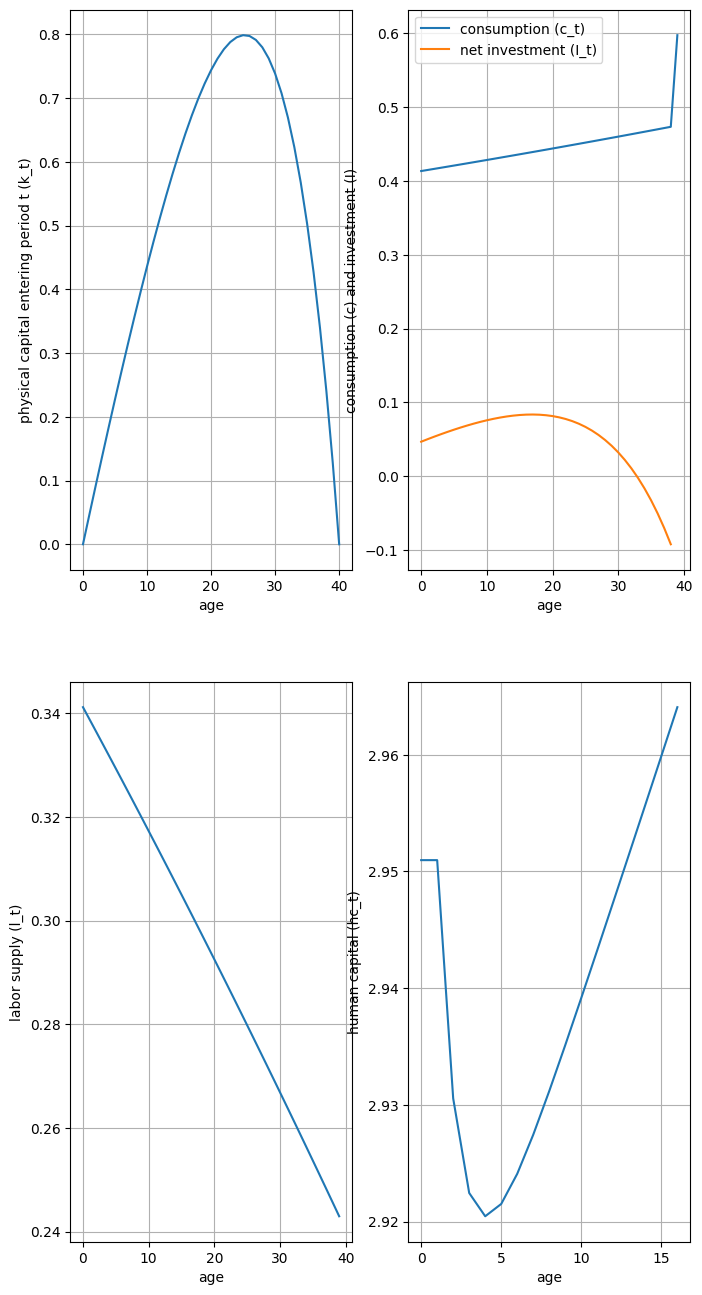

iter: 3; K change: 0.05; H change: 0.05; L change: 0.00; Z change: 0.09
y: 0.6189684093221193
ie: 0.03713810455932715
tax_revenue: 0.06438440536434573
grants: 0.043327788652548355
T: 0.03343598489823978
iter: 3; K: 0.66; H: 2.48; L: 0.29; Z: 0.14
iter: 3; Y: 0.62; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.01778718 0.01764657 0.01749696 0.01733785 0.01716871 0.01698902
  0.01679823 0.01659577 0.01638105 0.0161535  0.01591248 0.01565737
  0.01538754 0.01510232 0.01480102 0.01448296 0.01414745 0.01379377
  0.01342122 0.01302909 0.01261664 0.01218315 0.0117279  0.01125017
  0.01074922 0.01022436 0.00967488 0.00910008 0.00849928 0.00787183
  0.00721706 0.00653437 0.00582313 0.00508276 0.00431272 0.00351247
  0.00268152 0.00181941 0.0009257  0.        ]
 [0.01778978 0.01764916 0.01749953 0.01734039 0.01717123 0.01699151
  0.01680069 0.0165982  0.01638345 0.01615587 0.01591481 0.01565967
  0.0153898  0.01510453 0.01480319 0.01448509 0.01414952 0.01379579
  0.01342319 0.01303

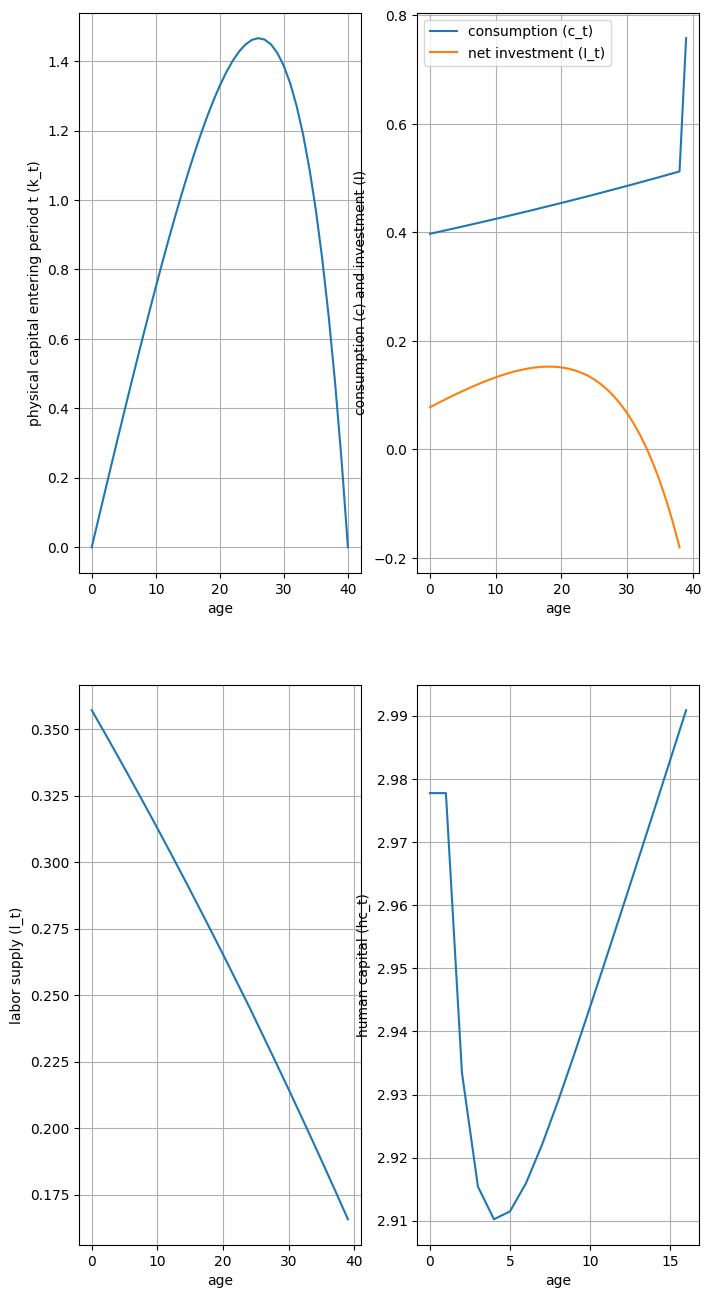

iter: 4; K change: 0.08; H change: 0.04; L change: 0.02; Z change: 0.08
y: 0.6449857253849933
ie: 0.0386991435230996
tax_revenue: 0.06662186438825657
grants: 0.045149000776949534
T: 0.0343725781190069
iter: 4; K: 0.72; H: 2.58; L: 0.29; Z: 0.15
iter: 4; Y: 0.64; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.01399619 0.01387081 0.01373818 0.01359794 0.01344974 0.0132932
  0.01312795 0.0129536  0.01276974 0.01257598 0.01237188 0.01215704
  0.01193102 0.01169338 0.01144368 0.01118148 0.01090632 0.01061775
  0.01031531 0.00999855 0.00966701 0.00932025 0.00895779 0.0085792
  0.00818405 0.00777189 0.0073423  0.00689486 0.00642916 0.00594482
  0.00544144 0.00491867 0.00437615 0.00381355 0.00323054 0.00262686
  0.0020022  0.00135633 0.000689   0.        ]
 [0.01399823 0.01387284 0.01374019 0.01359993 0.01345171 0.01329515
  0.01312988 0.0129555  0.01277162 0.01257781 0.01237369 0.01215882
  0.01193276 0.01169509 0.01144535 0.01118311 0.01090792 0.0106193
  0.01031682 0.01000001 0

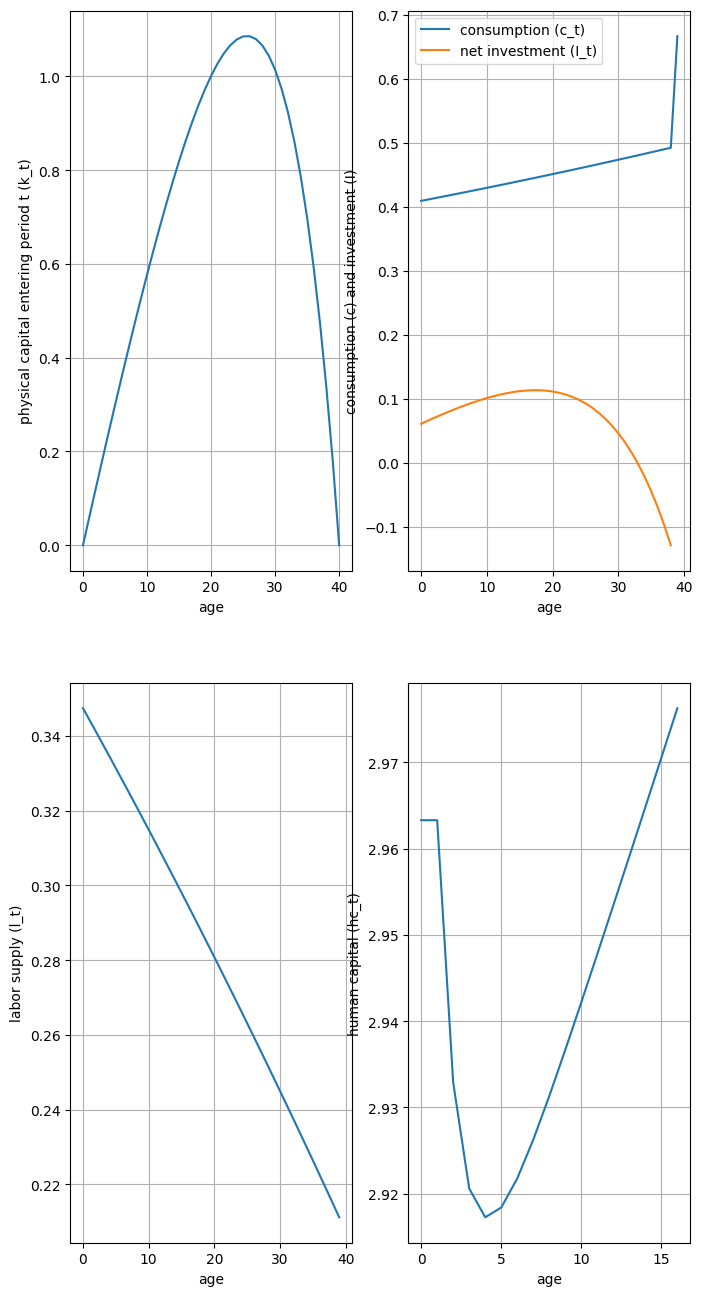

iter: 5; K change: 0.00; H change: 0.03; L change: 0.00; Z change: 0.07
y: 0.659784282556706
ie: 0.03958705695340236
tax_revenue: 0.06841556867472945
grants: 0.04618489977896942
T: 0.03542635454689414
iter: 5; K: 0.72; H: 2.66; L: 0.29; Z: 0.16
iter: 5; Y: 0.66; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01630694 0.0161704  0.01602548 0.01587176 0.01570879 0.01553611
  0.01535325 0.01515972 0.01495503 0.01473865 0.01451005 0.01426871
  0.01401406 0.01374553 0.01346257 0.01316459 0.012851   0.01252123
  0.01217466 0.0118107  0.01142874 0.0110282  0.01060847 0.01016895
  0.00970904 0.00922818 0.00872578 0.00820127 0.00765412 0.00708377
  0.00648971 0.00587144 0.00522845 0.0045603  0.00386654 0.00314676
  0.00240057 0.00162759 0.00082751 0.        ]
 [0.01630932 0.01617275 0.01602782 0.01587408 0.01571108 0.01553838
  0.01535549 0.01516193 0.01495721 0.0147408  0.01451217 0.01427079
  0.0140161  0.01374754 0.01346454 0.01316651 0.01285288 0.01252305
  0.01217643 0.0118124

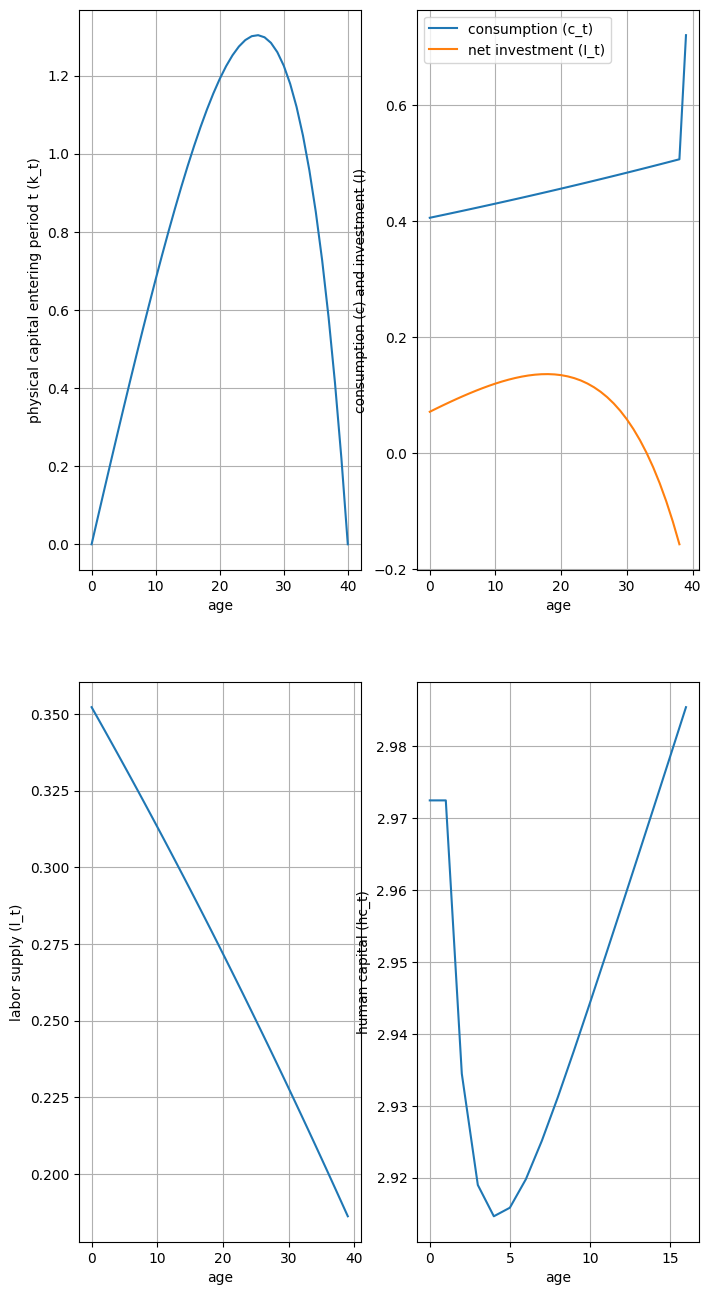

iter: 6; K change: 0.04; H change: 0.02; L change: 0.01; Z change: 0.07
y: 0.675747774459557
ie: 0.04054486646757342
tax_revenue: 0.06992821241777408
grants: 0.047302344212168994
T: 0.03614082369479624
iter: 6; K: 0.74; H: 2.72; L: 0.28; Z: 0.17
iter: 6; Y: 0.68; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01525366 0.01512125 0.01498096 0.01483242 0.01467519 0.01450888
  0.01433306 0.01414729 0.01395112 0.01374408 0.0135257  0.0132955
  0.01305298 0.01279765 0.01252901 0.01224654 0.01194972 0.01163802
  0.01131094 0.01096793 0.01060848 0.01023204 0.00983812 0.00942618
  0.0089957  0.00854619 0.00807714 0.00758806 0.00707849 0.00654795
  0.00599601 0.00542221 0.00482615 0.00420744 0.00356569 0.00290057
  0.00221173 0.00149887 0.00076171 0.        ]
 [0.01525588 0.01512345 0.01498315 0.01483457 0.01467733 0.014511
  0.01433515 0.01414935 0.01395315 0.01374608 0.01352767 0.01329744
  0.01305488 0.01279952 0.01253083 0.01224832 0.01195145 0.01163972
  0.01131259 0.01096953 

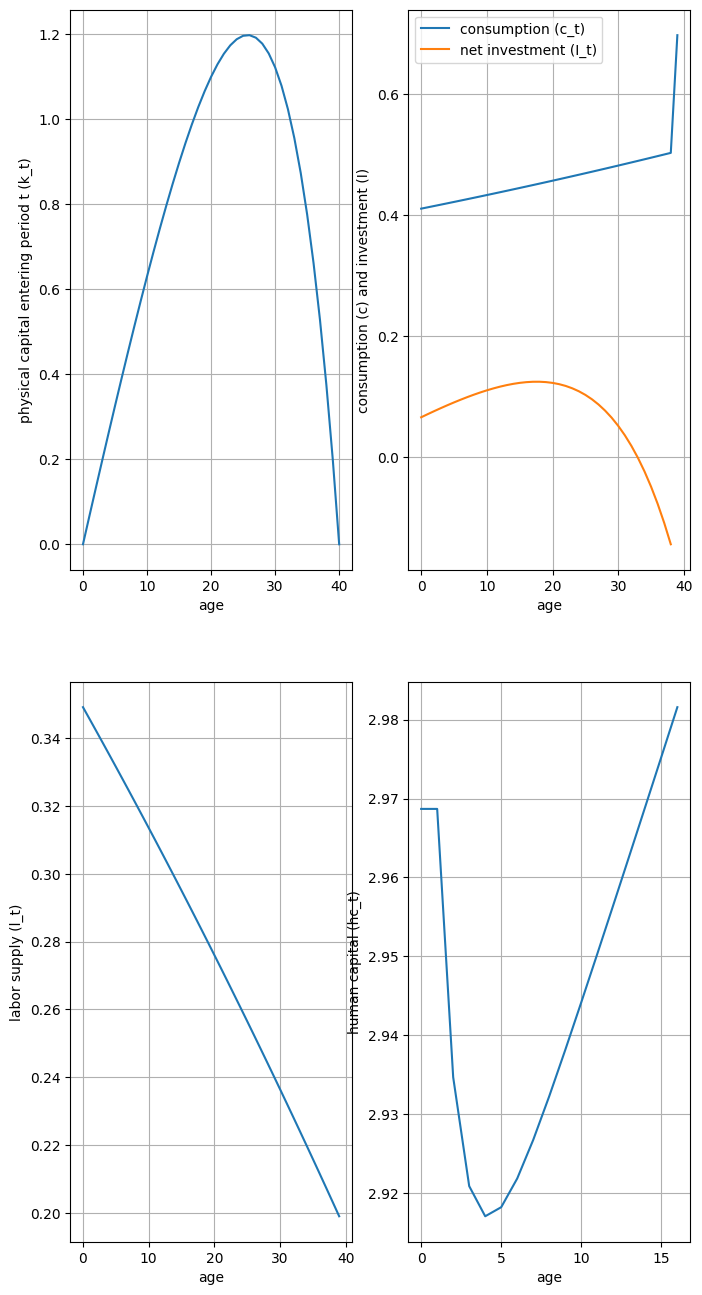

iter: 7; K change: 0.01; H change: 0.02; L change: 0.00; Z change: 0.06
y: 0.6872114107876826
ie: 0.04123268464726095
tax_revenue: 0.07118372831871678
grants: 0.04810479875513778
T: 0.036823157779332656
iter: 7; K: 0.75; H: 2.78; L: 0.28; Z: 0.18
iter: 7; Y: 0.69; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01590811 0.01577235 0.0156284  0.01547584 0.01531425 0.01514318
  0.01496219 0.0147708  0.01456854 0.01435491 0.01412942 0.01389155
  0.01364076 0.01337653 0.01309832 0.01280556 0.01249773 0.01217426
  0.01183456 0.0114781  0.01110429 0.01071257 0.01030238 0.00987315
  0.00942433 0.00895538 0.00846575 0.00795491 0.00742236 0.00686759
  0.0062901  0.00568942 0.00506512 0.00441676 0.00374391 0.00304621
  0.0023233  0.00157482 0.00080048 0.        ]
 [0.01591042 0.01577464 0.01563067 0.01547809 0.01531647 0.01514538
  0.01496436 0.01477295 0.01457065 0.014357   0.01413148 0.01389357
  0.01364274 0.01337847 0.01310022 0.01280743 0.01249955 0.01217602
  0.01183629 0.01147

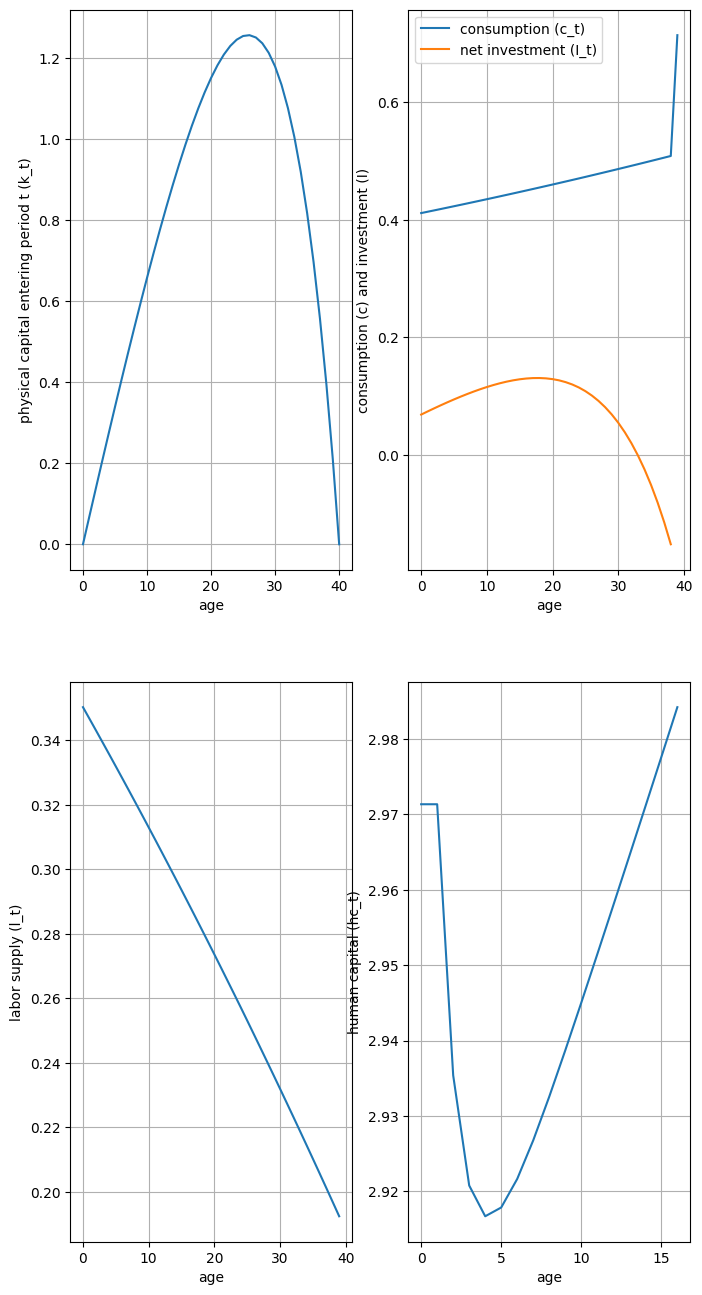

iter: 8; K change: 0.02; H change: 0.01; L change: 0.01; Z change: 0.05
y: 0.6977789780768524
ie: 0.041866738684611146
tax_revenue: 0.07224076696667345
grants: 0.04884452846537967
T: 0.03735181806283083
iter: 8; K: 0.77; H: 2.82; L: 0.28; Z: 0.19
iter: 8; Y: 0.70; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01569905 0.01556385 0.01542055 0.01526874 0.01510802 0.01493795
  0.01475808 0.01456796 0.01436713 0.0141551  0.01393137 0.01369546
  0.01344684 0.013185   0.0129094  0.01261953 0.01231482 0.01199476
  0.01165878 0.01130633 0.01093686 0.01054983 0.01014469 0.00972089
  0.00927791 0.0088152  0.00833224 0.00782853 0.00730357 0.00675686
  0.00618794 0.00559636 0.00498167 0.00434347 0.00368135 0.00299496
  0.00228394 0.00154796 0.00078674 0.        ]
 [0.01570133 0.01556611 0.01542279 0.01527096 0.01511021 0.01494011
  0.01476021 0.01457007 0.01436921 0.01415715 0.0139334  0.01369745
  0.01344879 0.01318691 0.01291127 0.01262136 0.01231661 0.0119965
  0.01166047 0.011307

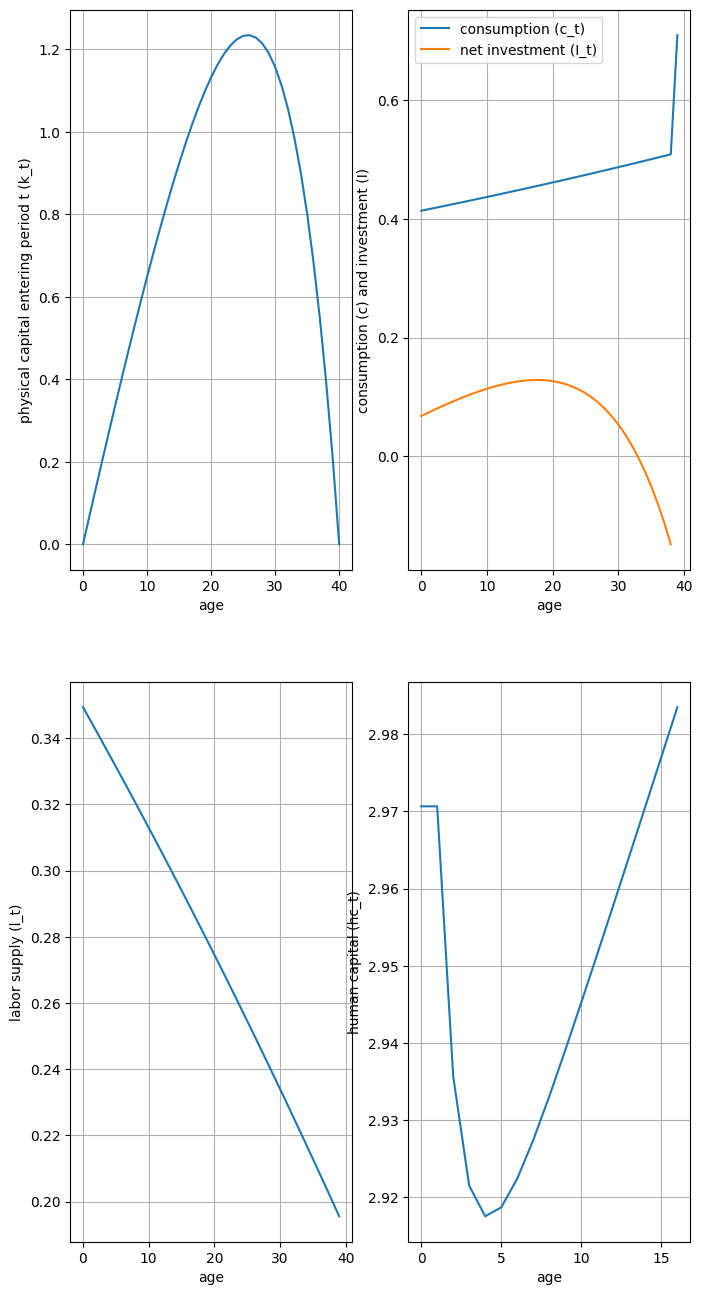

iter: 9; K change: 0.01; H change: 0.01; L change: 0.00; Z change: 0.05
y: 0.7062640137270494
ie: 0.04237584082362296
tax_revenue: 0.0731333610465764
grants: 0.04943848096089346
T: 0.03782016036022395
iter: 9; K: 0.77; H: 2.85; L: 0.28; Z: 0.20
iter: 9; Y: 0.71; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.0158949  0.01575847 0.01561385 0.01546063 0.01529837 0.01512665
  0.014945   0.01475298 0.01455011 0.01433589 0.01410983 0.0138714
  0.01362011 0.01335541 0.01307676 0.01278364 0.01247548 0.01215173
  0.01181184 0.01145524 0.01108138 0.0106897  0.01027963 0.00985062
  0.00940214 0.00893362 0.00844455 0.0079344  0.00740267 0.00684884
  0.00627246 0.00567305 0.00505016 0.00440338 0.00373229 0.00303654
  0.00231575 0.00156959 0.00079777 0.        ]
 [0.0158972  0.01576076 0.01561612 0.01546287 0.01530059 0.01512884
  0.01494718 0.01475513 0.01455222 0.01433797 0.01411187 0.01387341
  0.01362208 0.01335734 0.01307866 0.01278549 0.01247728 0.01215349
  0.01181355 0.0114569 

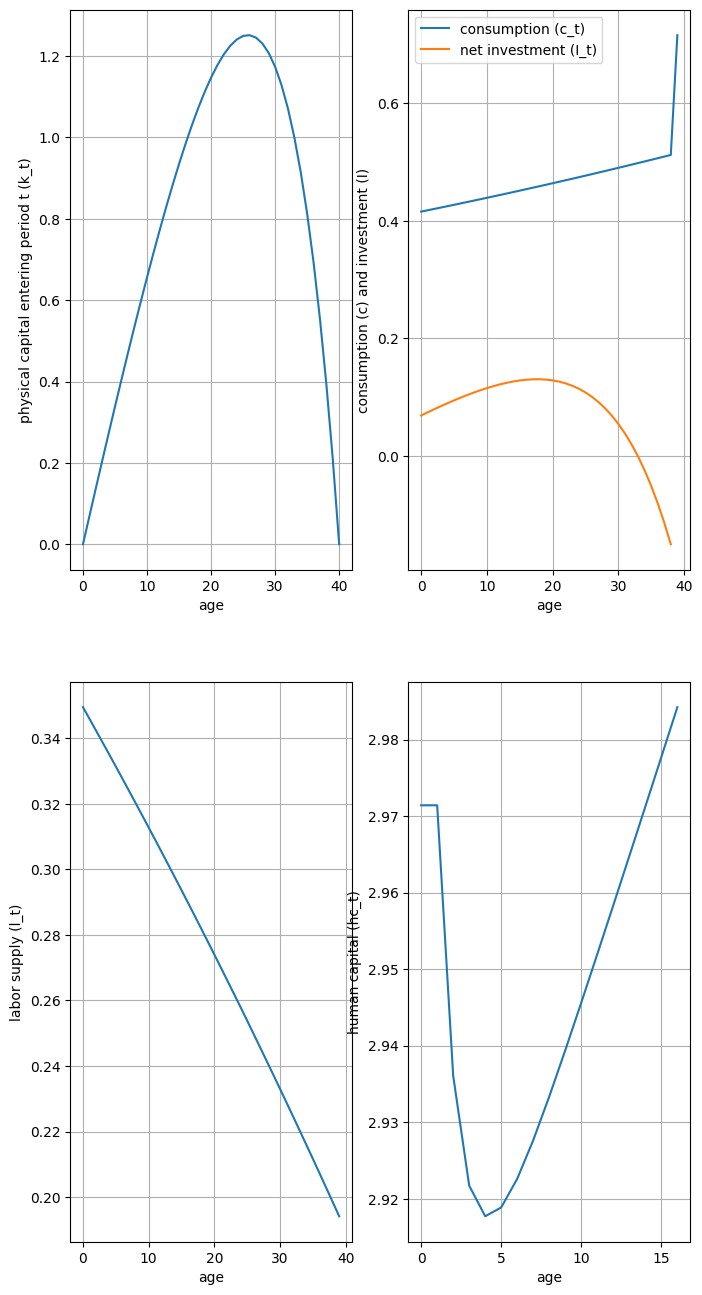

iter: 10; K change: 0.01; H change: 0.01; L change: 0.00; Z change: 0.04
y: 0.7136885776377726
ie: 0.04282131465826636
tax_revenue: 0.07389192276492215
grants: 0.049958200434644086
T: 0.038207493883033516
iter: 10; K: 0.78; H: 2.88; L: 0.28; Z: 0.21
iter: 10; Y: 0.71; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01589131 0.01575459 0.01560967 0.01545614 0.01529359 0.01512156
  0.01493962 0.0147473  0.01454414 0.01432965 0.01410331 0.01386463
  0.01361308 0.01334815 0.01306929 0.01277597 0.01246763 0.01214373
  0.01180372 0.01144702 0.01107309 0.01068137 0.0102713  0.00984234
  0.00939393 0.00892554 0.00843665 0.00792673 0.00739527 0.00684178
  0.00626579 0.00566684 0.00504448 0.00439828 0.00372786 0.00303283
  0.00231285 0.00156757 0.00079672 0.        ]
 [0.01589361 0.01575687 0.01561193 0.01545838 0.0152958  0.01512374
  0.01494178 0.01474944 0.01454625 0.01433172 0.01410535 0.01386664
  0.01361506 0.01335008 0.01307118 0.01277782 0.01246944 0.01214549
  0.01180542 0.0

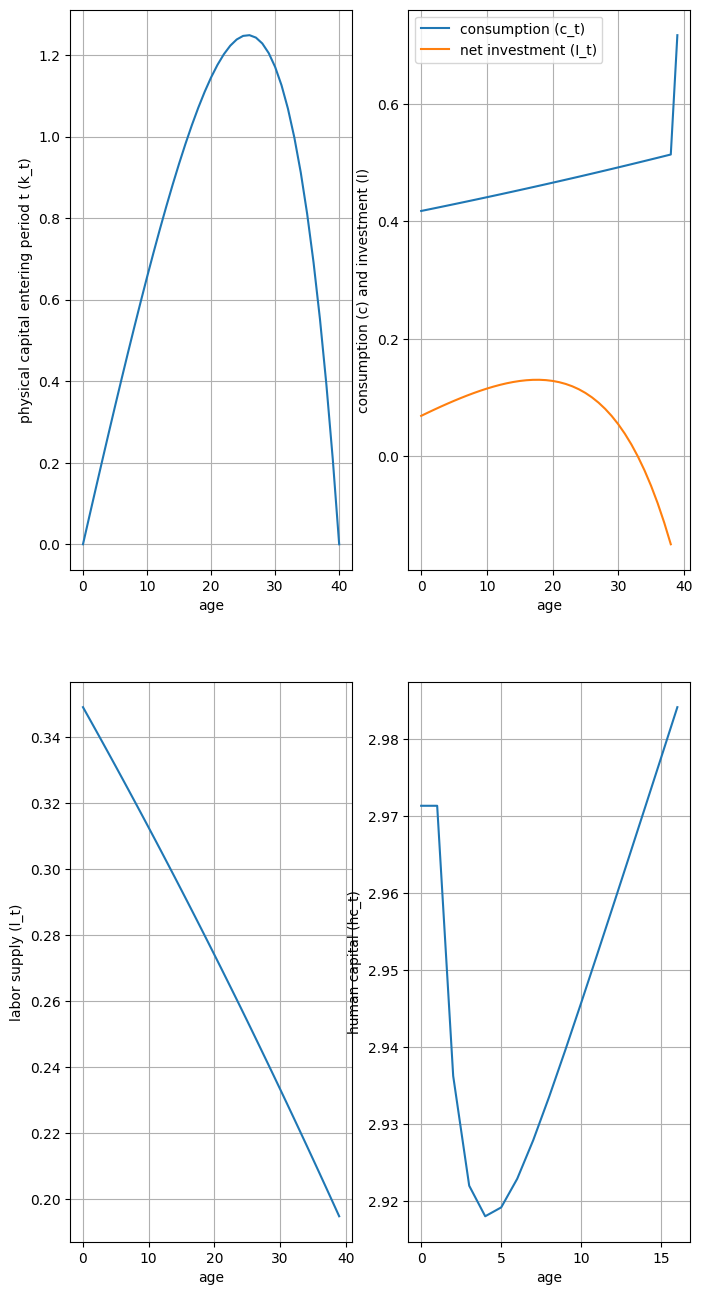

iter: 11; K change: 0.01; H change: 0.01; L change: 0.00; Z change: 0.04
y: 0.7199387064703587
ie: 0.04319632238822152
tax_revenue: 0.0745402307334246
grants: 0.05039570945292512
T: 0.03854329540990667
iter: 11; K: 0.79; H: 2.90; L: 0.28; Z: 0.22
iter: 11; Y: 0.72; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01597164 0.01583425 0.01568864 0.01553438 0.01537104 0.01519818
  0.01501537 0.01482212 0.01461797 0.01440242 0.01417498 0.01393514
  0.01368236 0.01341612 0.01313588 0.0128411  0.01253124 0.01220572
  0.01186401 0.01150554 0.01112974 0.01073605 0.01032392 0.0098928
  0.00944212 0.00897137 0.00847999 0.00796747 0.00743332 0.00687701
  0.00629808 0.00569606 0.0050705  0.00442099 0.00374712 0.00304851
  0.00232482 0.00157569 0.00080085 0.        ]
 [0.01597395 0.01583655 0.01569091 0.01553662 0.01537326 0.01520039
  0.01501754 0.01482427 0.01462009 0.01440451 0.01417704 0.01393715
  0.01368434 0.01341806 0.01313778 0.01284296 0.01253305 0.01220749
  0.01186573 0.01150

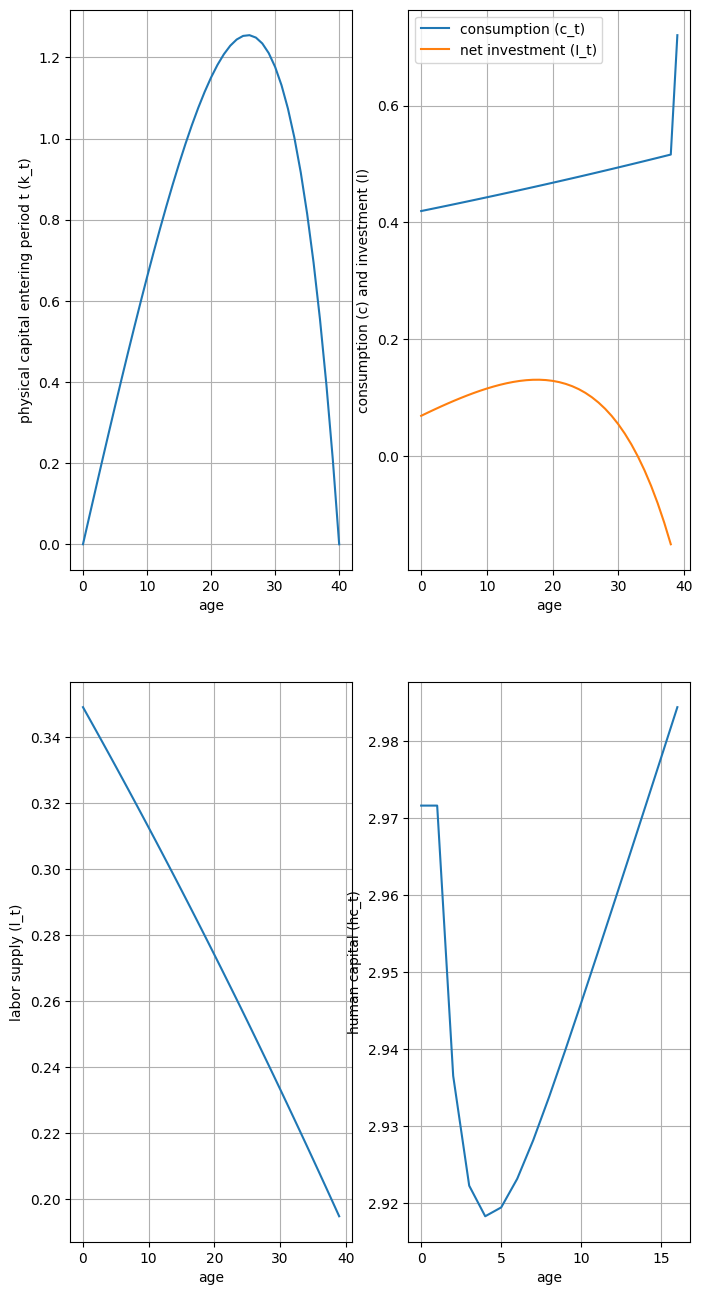

iter: 12; K change: 0.01; H change: 0.01; L change: 0.00; Z change: 0.03
y: 0.7253548312304609
ie: 0.04352128987382765
tax_revenue: 0.07509715512891693
grants: 0.050774838186132265
T: 0.03882941356739391
iter: 12; K: 0.80; H: 2.92; L: 0.28; Z: 0.23
iter: 12; Y: 0.73; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01600644 0.01586865 0.01572259 0.01556787 0.01540405 0.01523069
  0.01504735 0.01485356 0.01464884 0.0144327  0.01420464 0.01396415
  0.01371071 0.01344379 0.01316283 0.01286731 0.01255668 0.01223038
  0.01188785 0.01152852 0.01115184 0.01075725 0.01034419 0.00991211
  0.00946045 0.00898867 0.00849625 0.00798266 0.00744739 0.00688995
  0.00630985 0.00570664 0.00507987 0.0044291  0.00375395 0.00305403
  0.002329   0.00157851 0.00080227 0.        ]
 [0.01600877 0.01587095 0.01572487 0.01557012 0.01540628 0.0152329
  0.01504953 0.01485571 0.01465096 0.01443479 0.0142067  0.01396618
  0.0137127  0.01344573 0.01316473 0.01286918 0.0125585  0.01223214
  0.01188956 0.011

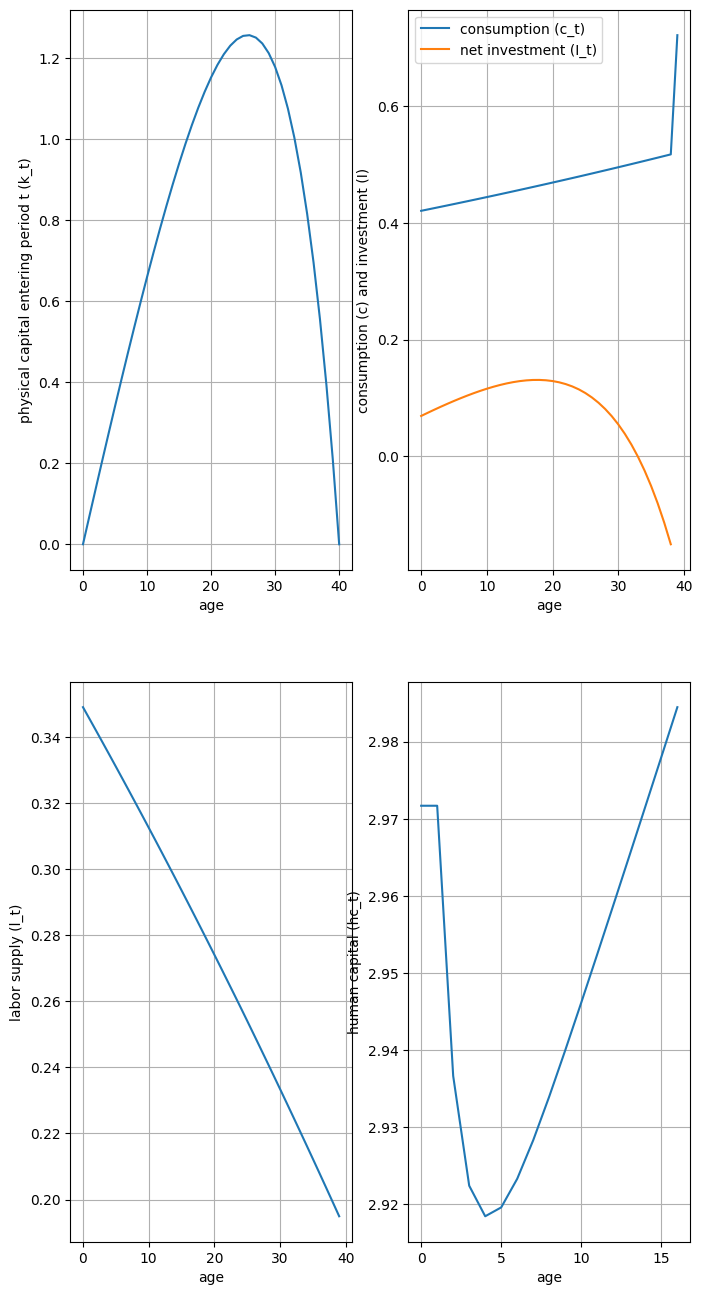

iter: 13; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.03
y: 0.7300136273735567
ie: 0.0438008176424134
tax_revenue: 0.07557812449748712
grants: 0.051100953916148974
T: 0.03907744312880931
iter: 13; K: 0.80; H: 2.93; L: 0.28; Z: 0.24
iter: 13; Y: 0.73; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01605514 0.01591688 0.01577034 0.0156151  0.01545074 0.01527681
  0.01509286 0.01489844 0.01469305 0.01447621 0.01424742 0.01400615
  0.0137519  0.01348412 0.01320228 0.01290583 0.01259422 0.01226689
  0.0119233  0.01156285 0.01118501 0.0107892  0.01037488 0.00994147
  0.00948843 0.00901522 0.00852131 0.00800617 0.0074693  0.00691019
  0.00632836 0.00572336 0.00509472 0.00444204 0.0037649  0.00306293
  0.00233577 0.00158309 0.00080459 0.        ]
 [0.01605747 0.01591918 0.01577262 0.01561736 0.01545297 0.01527902
  0.01509505 0.01490059 0.01469518 0.01447831 0.01424948 0.01400818
  0.01375389 0.01348608 0.01320419 0.0129077  0.01259604 0.01226867
  0.01192502 0.011

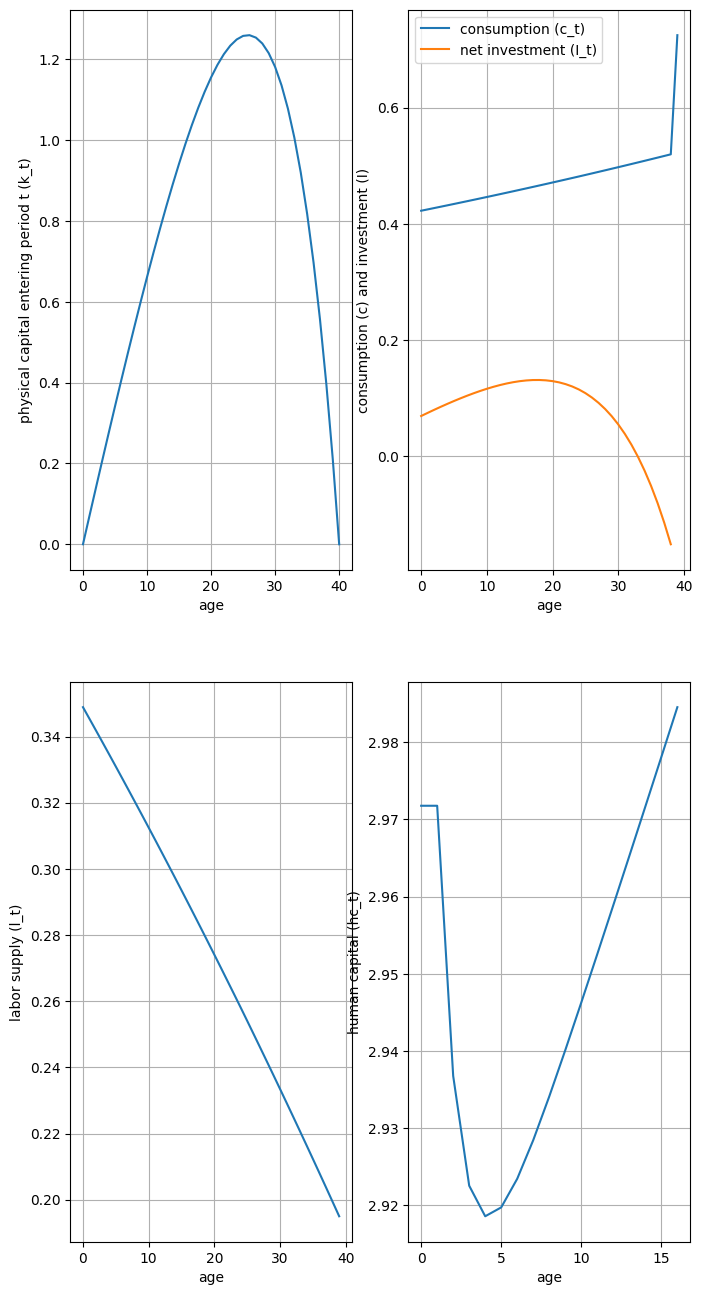

iter: 14; K change: 0.01; H change: 0.00; L change: 0.00; Z change: 0.03
y: 0.7340664881526849
ie: 0.044043989289161097
tax_revenue: 0.0759954591544561
grants: 0.05138465417068795
T: 0.039292134746821854
iter: 14; K: 0.81; H: 2.94; L: 0.28; Z: 0.24
iter: 14; Y: 0.73; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01609171 0.01595306 0.01580611 0.01565044 0.01548563 0.01531124
  0.0151268  0.01493186 0.01472593 0.01450853 0.01427915 0.01403727
  0.01378237 0.01351391 0.01323137 0.01293419 0.01262182 0.0122937
  0.01194927 0.01158797 0.01120923 0.0108125  0.0103972  0.0099628
  0.00950872 0.00903444 0.00853942 0.00802313 0.00748507 0.00692473
  0.00634164 0.00573532 0.00510534 0.00445127 0.00377269 0.00306925
  0.00234058 0.00158634 0.00080624 0.        ]
 [0.01609403 0.01595537 0.0158084  0.01565271 0.01548787 0.01531345
  0.01512899 0.01493402 0.01472806 0.01451062 0.01428121 0.0140393
  0.01378436 0.01351587 0.01323328 0.01293606 0.01262364 0.01229547
  0.01195099 0.01158

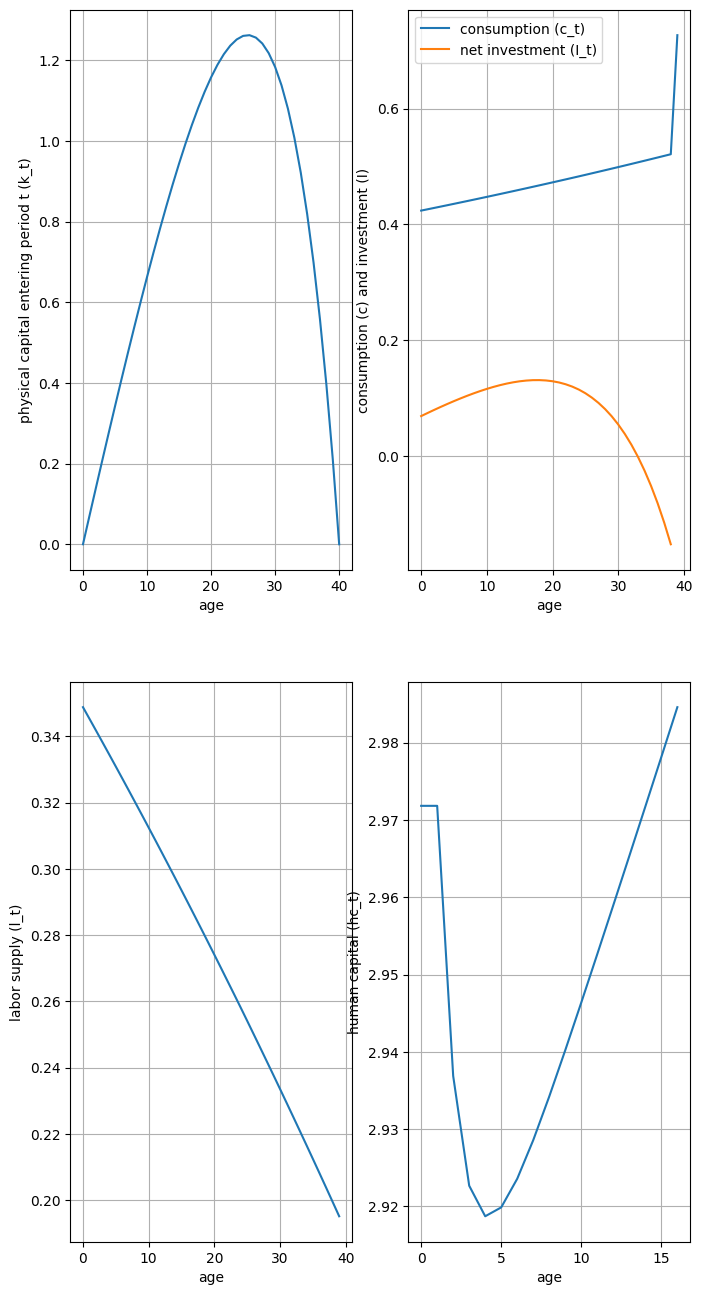

iter: 15; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.03
y: 0.7375965775746863
ie: 0.04425579465448118
tax_revenue: 0.07635926887474113
grants: 0.051631760430228046
T: 0.03947943999600684
iter: 15; K: 0.81; H: 2.95; L: 0.28; Z: 0.25
iter: 15; Y: 0.74; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01612827 0.01598925 0.01584192 0.01568585 0.01552061 0.01534577
  0.01516085 0.01496542 0.01475897 0.01454102 0.01431106 0.01406859
  0.01381306 0.01354395 0.01326072 0.01296282 0.0126497  0.0123208
  0.01197556 0.01161341 0.01123378 0.01083613 0.01041988 0.00998447
  0.00952937 0.00905401 0.00855788 0.00804044 0.00750118 0.00693959
  0.00635522 0.00574758 0.00511622 0.00446073 0.0037807  0.00307575
  0.00234552 0.00158968 0.00080794 0.        ]
 [0.0161306  0.01599156 0.0158442  0.01568811 0.01552285 0.01534798
  0.01516305 0.01496758 0.0147611  0.01454312 0.01431313 0.01407062
  0.01381505 0.01354591 0.01326264 0.01296469 0.01265153 0.01232258
  0.01197729 0.011

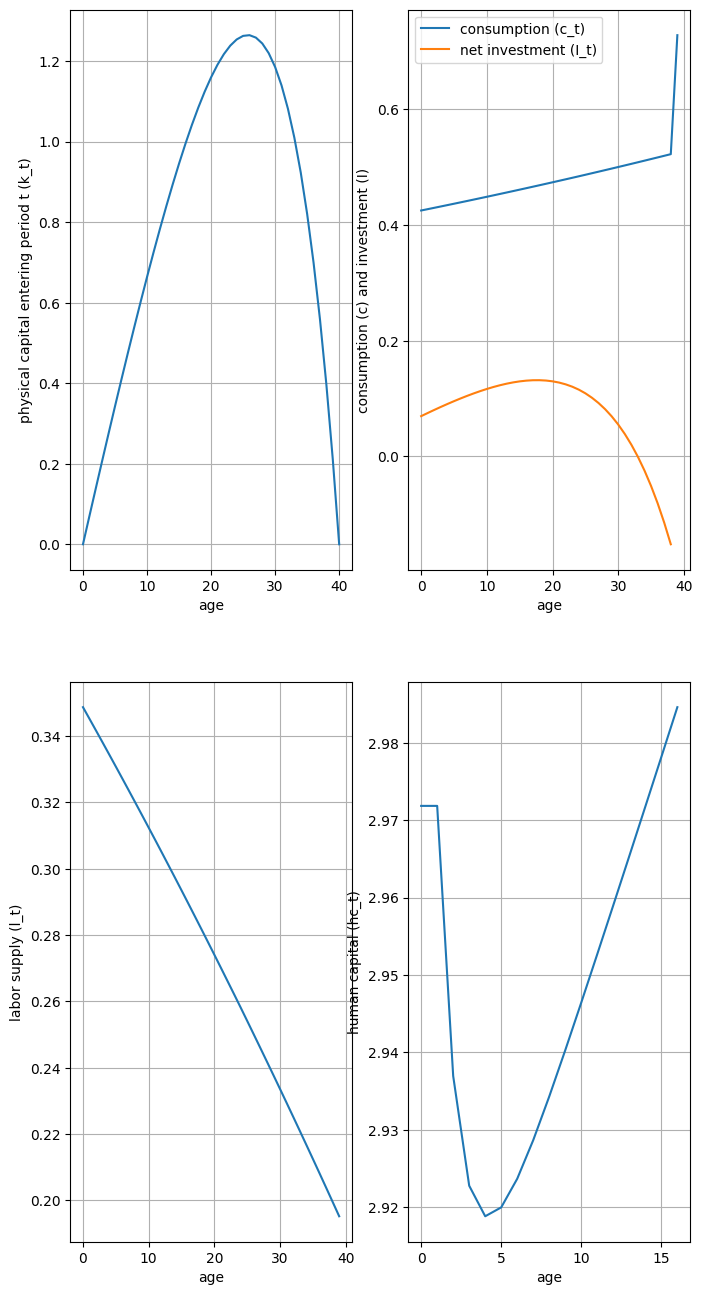

iter: 16; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.7406896426426779
ie: 0.044441378558560674
tax_revenue: 0.07667776738292592
grants: 0.05184827498498746
T: 0.039643285250792026
iter: 16; K: 0.81; H: 2.96; L: 0.28; Z: 0.26
iter: 16; Y: 0.74; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01616    0.01602065 0.01587297 0.01571654 0.01555092 0.01537568
  0.01519035 0.01499447 0.01478756 0.01456913 0.01433867 0.01409567
  0.01383959 0.0135699  0.01328607 0.01298754 0.01267376 0.01234417
  0.01199822 0.01163533 0.01125493 0.01085648 0.0104394  0.01000313
  0.00954712 0.00907084 0.00857374 0.00805529 0.007515   0.00695235
  0.00636686 0.00575808 0.00512555 0.00446884 0.00378755 0.0030813
  0.00234975 0.00159254 0.00080938 0.        ]
 [0.01616233 0.01602296 0.01587526 0.01571881 0.01555317 0.0153779
  0.01519254 0.01499664 0.0147897  0.01457123 0.01434074 0.0140977
  0.01384159 0.01357186 0.01328798 0.01298942 0.01267559 0.01234596
  0.01199995 0.0116

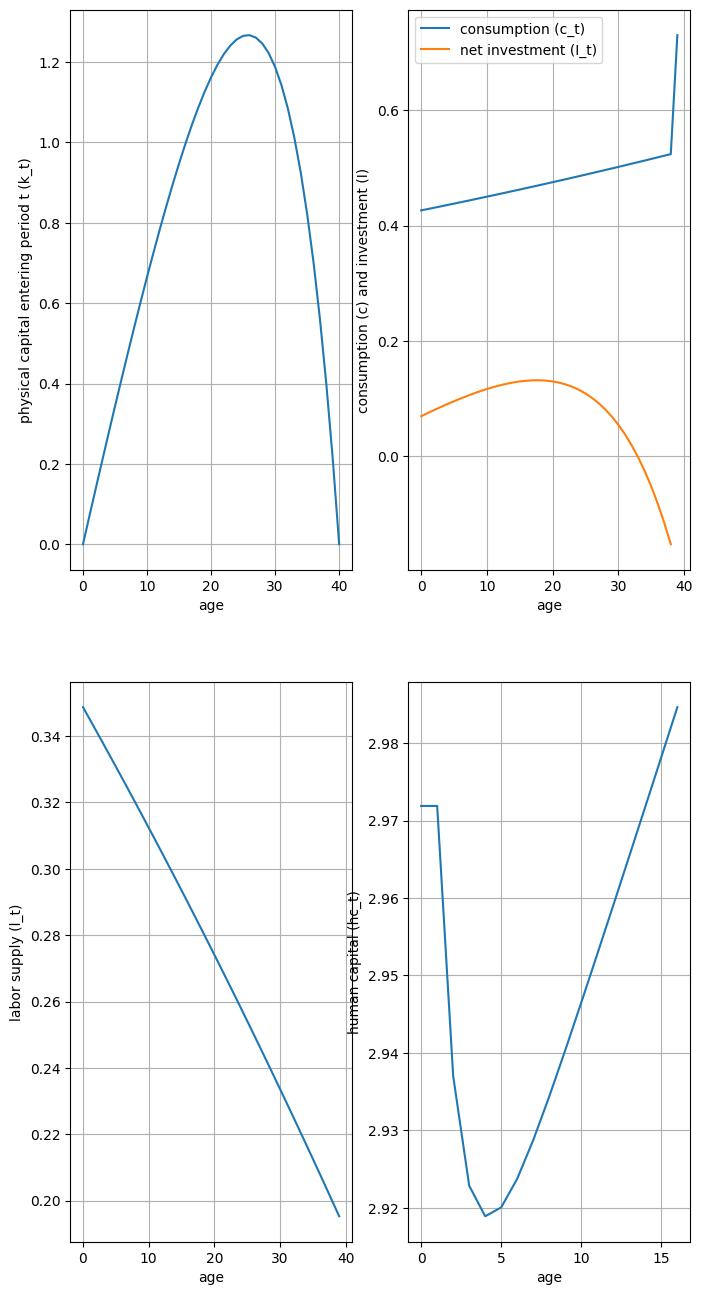

iter: 17; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.7434083383204083
ie: 0.0446045002992245
tax_revenue: 0.07695772484021159
grants: 0.052038583682428585
T: 0.03978730792419116
iter: 17; K: 0.82; H: 2.96; L: 0.28; Z: 0.26
iter: 17; Y: 0.74; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01618945 0.0160498  0.0159018  0.01574504 0.01557908 0.01540346
  0.01521775 0.01502147 0.01481413 0.01459525 0.01436433 0.01412084
  0.01386425 0.01359403 0.01330964 0.01301053 0.01269615 0.01236593
  0.01201932 0.01165574 0.01127463 0.01087543 0.01045757 0.0100205
  0.00956366 0.00908651 0.00858851 0.00806914 0.00752788 0.00696424
  0.00637772 0.00576788 0.00513424 0.0044764  0.00379395 0.00308649
  0.00235369 0.00159521 0.00081074 0.        ]
 [0.01619179 0.01605212 0.0159041  0.01574731 0.01558132 0.01540569
  0.01521995 0.01502364 0.01481627 0.01459736 0.0143664  0.01412287
  0.01386625 0.01359599 0.01331156 0.01301241 0.01269798 0.01236772
  0.01202105 0.0116

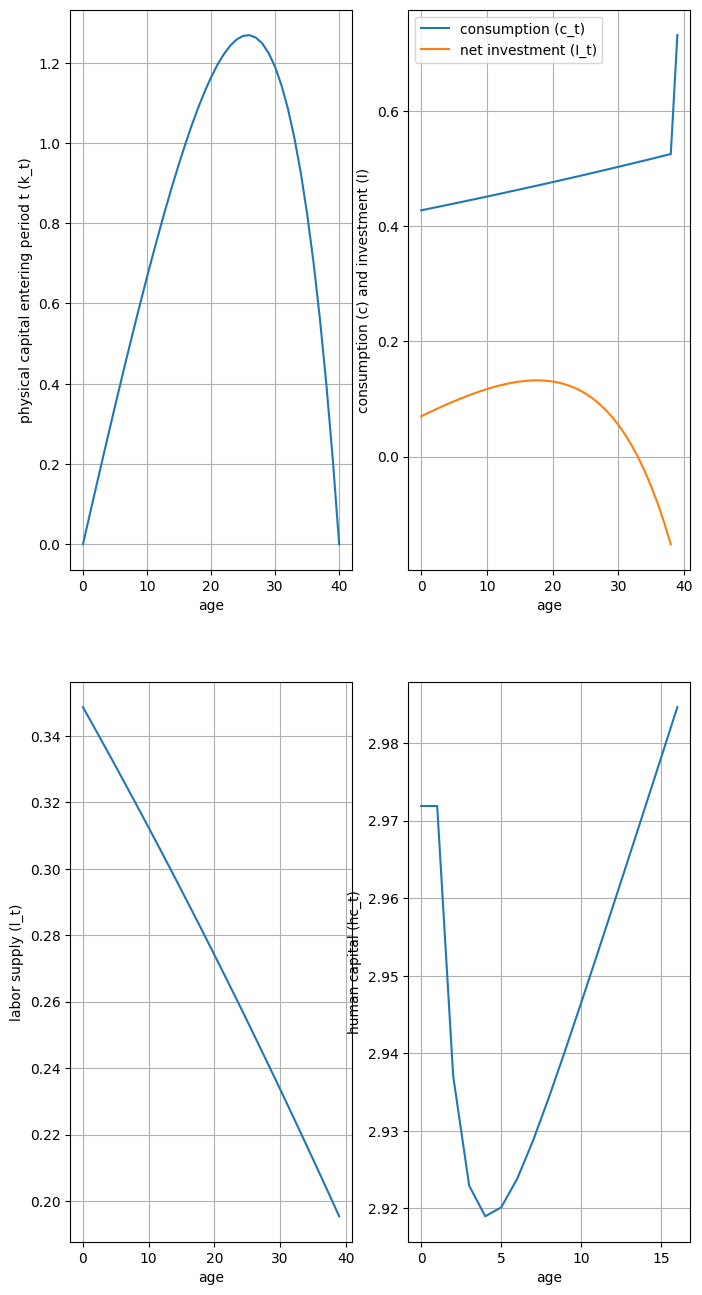

iter: 18; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.7458078222876574
ie: 0.04474846933725944
tax_revenue: 0.07720471927948716
grants: 0.05220654756013603
T: 0.03991432816510429
iter: 18; K: 0.82; H: 2.97; L: 0.28; Z: 0.27
iter: 18; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01621593 0.016076   0.01592772 0.01577066 0.01560437 0.01542843
  0.01524237 0.01504572 0.014838   0.01461873 0.01438738 0.01414344
  0.01388639 0.01361569 0.01333081 0.01303117 0.01271624 0.01238545
  0.01203825 0.01167405 0.0112923  0.01089243 0.01047388 0.01003608
  0.00957849 0.00910056 0.00860176 0.00808155 0.00753943 0.00697489
  0.00638746 0.00577665 0.00514204 0.00448318 0.00379967 0.00309114
  0.00235723 0.00159759 0.00081195 0.        ]
 [0.01621827 0.01607833 0.01593002 0.01577293 0.01560663 0.01543066
  0.01524457 0.0150479  0.01484015 0.01462084 0.01438945 0.01414549
  0.01388841 0.01361767 0.01333273 0.01303306 0.01271808 0.01238725
  0.01203998 0.011

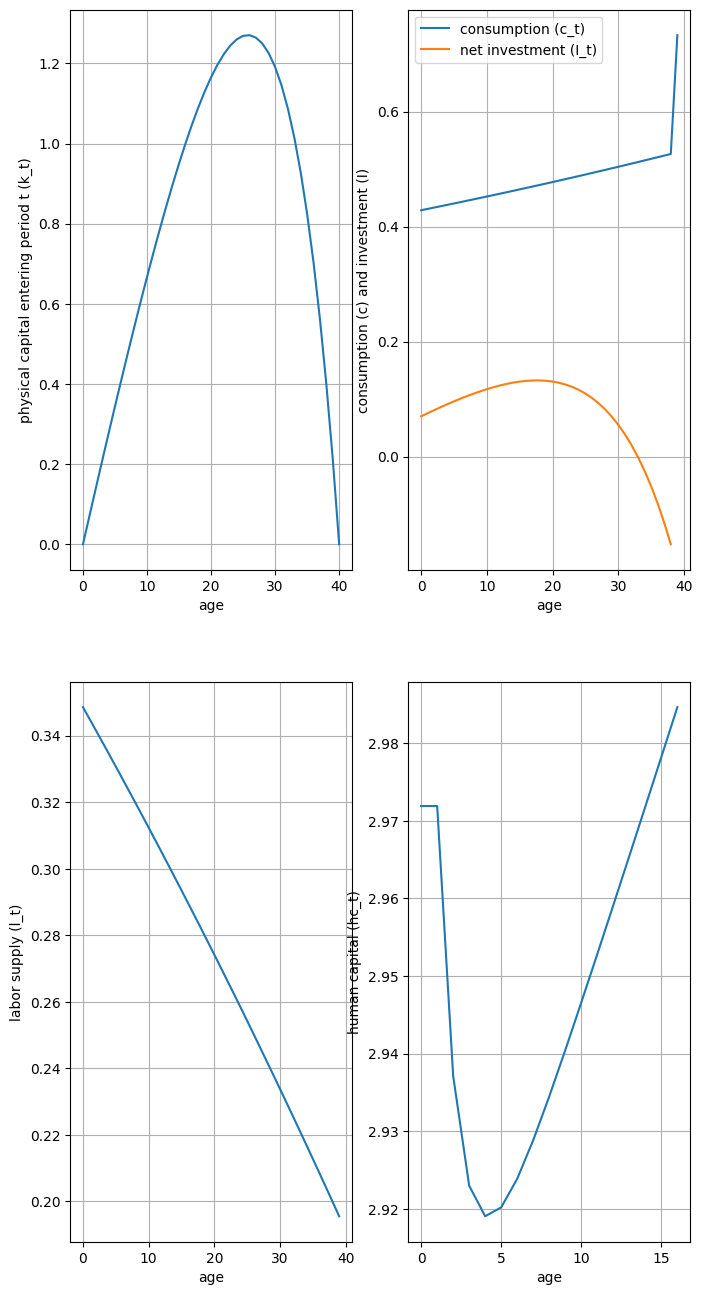

iter: 19; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.7479323796152664
ie: 0.04487594277691598
tax_revenue: 0.07742338409060856
grants: 0.05235526657306865
T: 0.040026765109845264
iter: 19; K: 0.82; H: 2.97; L: 0.28; Z: 0.27
iter: 19; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01624011 0.01609994 0.0159514  0.01579406 0.01562749 0.01545125
  0.01526486 0.01506788 0.01485982 0.01464017 0.01440844 0.0141641
  0.01390664 0.0136355  0.01335015 0.01305004 0.01273461 0.0124033
  0.01205555 0.01169079 0.01130845 0.01090796 0.01048878 0.01005033
  0.00959205 0.00911342 0.00861387 0.0080929  0.00754999 0.00698464
  0.00639636 0.00578468 0.00514916 0.00448937 0.00380491 0.00309539
  0.00236046 0.00159978 0.00081305 0.        ]
 [0.01624246 0.01610227 0.01595371 0.01579634 0.01562975 0.01545348
  0.01526707 0.01507006 0.01486197 0.01464229 0.01441052 0.01416615
  0.01390864 0.01363747 0.01335208 0.01305193 0.01273645 0.01240509
  0.01205729 0.0116

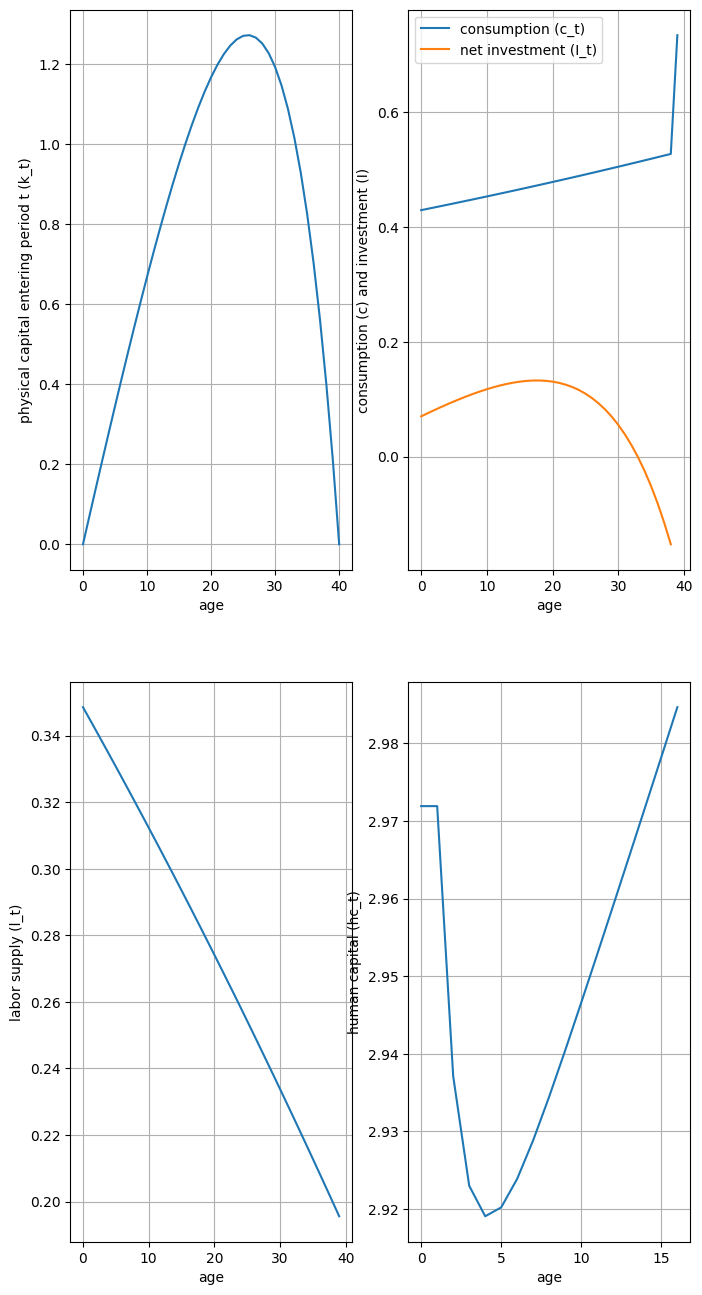

iter: 20; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.02
y: 0.7498195929751401
ie: 0.04498917557850841
tax_revenue: 0.07761758095282006
grants: 0.052487371508259814
T: 0.040126601304063085
iter: 20; K: 0.82; H: 2.97; L: 0.28; Z: 0.28
iter: 20; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01626208 0.01612169 0.0159729  0.01581531 0.01564848 0.01547196
  0.01528529 0.015088   0.01487962 0.01465964 0.01442756 0.01418286
  0.01392501 0.01365348 0.01336771 0.01306716 0.01275128 0.0124195
  0.01207125 0.01170598 0.01132311 0.01092207 0.0105023  0.01006325
  0.00960436 0.00912507 0.00862487 0.0081032  0.00755957 0.00699348
  0.00640443 0.00579196 0.00515562 0.00449499 0.00380966 0.00309924
  0.00236339 0.00160176 0.00081406 0.        ]
 [0.01626443 0.01612402 0.01597521 0.0158176  0.01565074 0.01547419
  0.0152875  0.01509018 0.01488177 0.01466176 0.01442965 0.01418491
  0.01392703 0.01365545 0.01336964 0.01306904 0.01275312 0.01242129
  0.012073   0.01

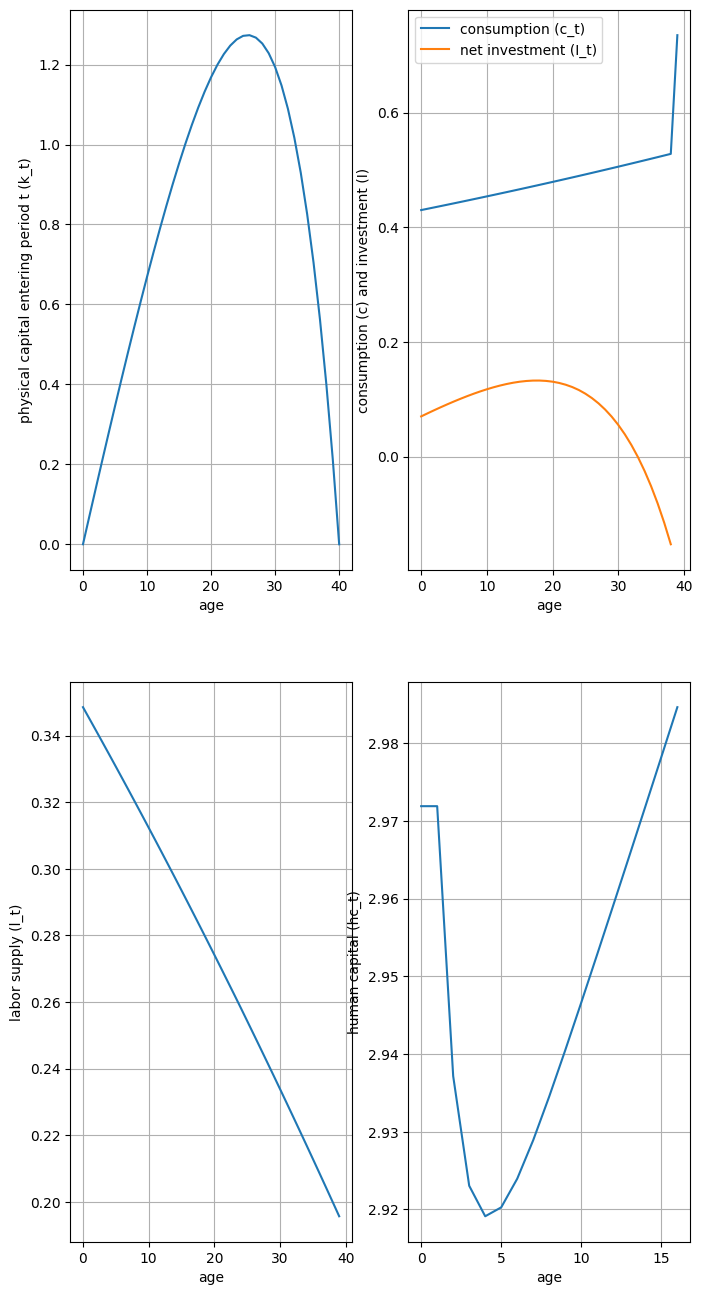

iter: 21; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.751500773025296
ie: 0.045090046381517764
tax_revenue: 0.07779054875455493
grants: 0.05260505411177073
T: 0.04021551010329016
iter: 21; K: 0.83; H: 2.98; L: 0.27; Z: 0.28
iter: 21; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01628207 0.01614147 0.01599247 0.01583465 0.01566758 0.01549081
  0.01530387 0.01510631 0.01489764 0.01467735 0.01444496 0.01419992
  0.01394173 0.01366983 0.01338368 0.01308274 0.01276644 0.01243423
  0.01208554 0.0117198  0.01133645 0.0109349  0.01051461 0.01007501
  0.00961555 0.00913568 0.00863486 0.00811257 0.00756829 0.00700152
  0.00641177 0.00579859 0.00516151 0.00450011 0.00381398 0.00310275
  0.00236606 0.00160356 0.00081497 0.        ]
 [0.01628442 0.01614379 0.01599478 0.01583694 0.01566984 0.01549305
  0.01530608 0.01510849 0.01489979 0.01467947 0.01444705 0.01420198
  0.01394374 0.0136718  0.01338562 0.01308463 0.01276829 0.01243603
  0.01208728 0.011

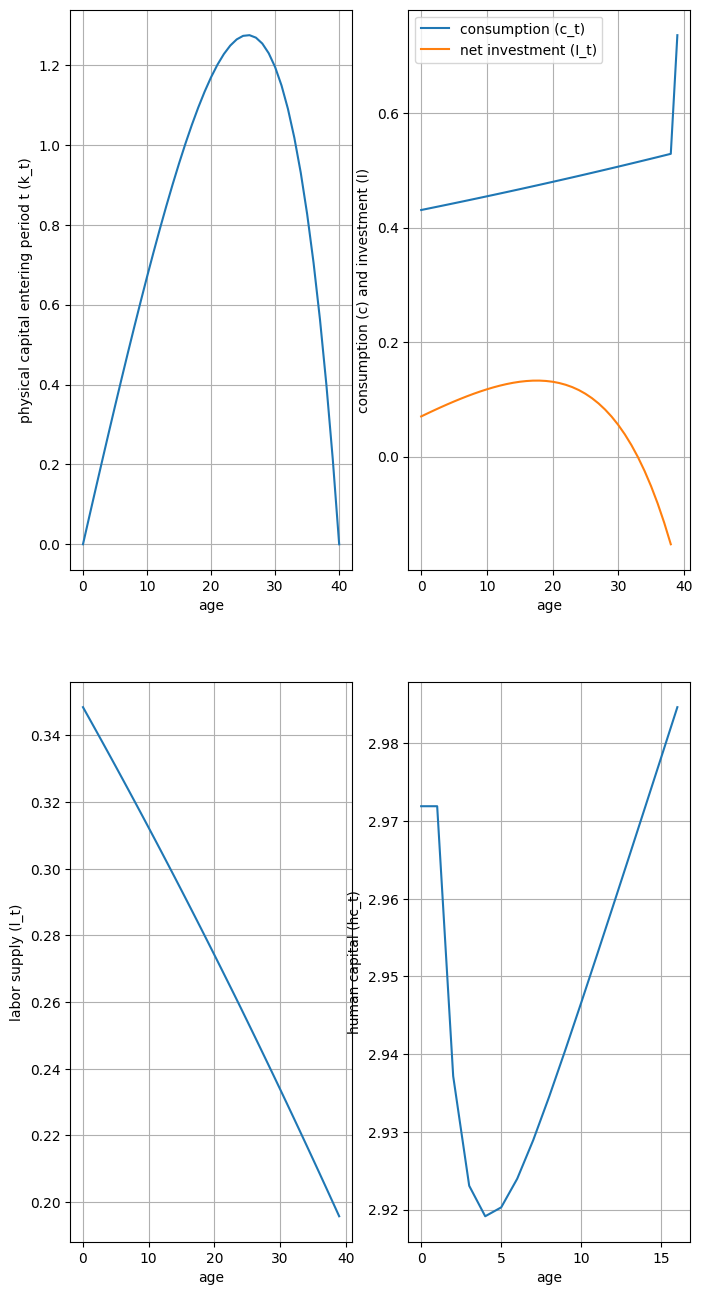

iter: 22; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7530023612382746
ie: 0.04518014167429647
tax_revenue: 0.07794501606766566
grants: 0.052710165286679225
T: 0.04029489800575195
iter: 22; K: 0.83; H: 2.98; L: 0.27; Z: 0.28
iter: 22; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01630024 0.01615946 0.01601026 0.01585223 0.01568494 0.01550795
  0.01532078 0.01512297 0.01491403 0.01469346 0.01446078 0.01421545
  0.01395693 0.01368471 0.01339821 0.01309691 0.01278024 0.01244763
  0.01209853 0.01173237 0.01134857 0.01094657 0.0105258  0.01008571
  0.00962573 0.00914533 0.00864396 0.00812109 0.00757622 0.00700884
  0.00641845 0.00580461 0.00516685 0.00450476 0.00381791 0.00310594
  0.00236848 0.0016052  0.0008158  0.        ]
 [0.0163026  0.01616179 0.01601257 0.01585453 0.01568722 0.01551019
  0.01532299 0.01512515 0.01491618 0.01469559 0.01446287 0.0142175
  0.01395895 0.01368668 0.01340015 0.01309881 0.01278209 0.01244943
  0.01210028 0.011

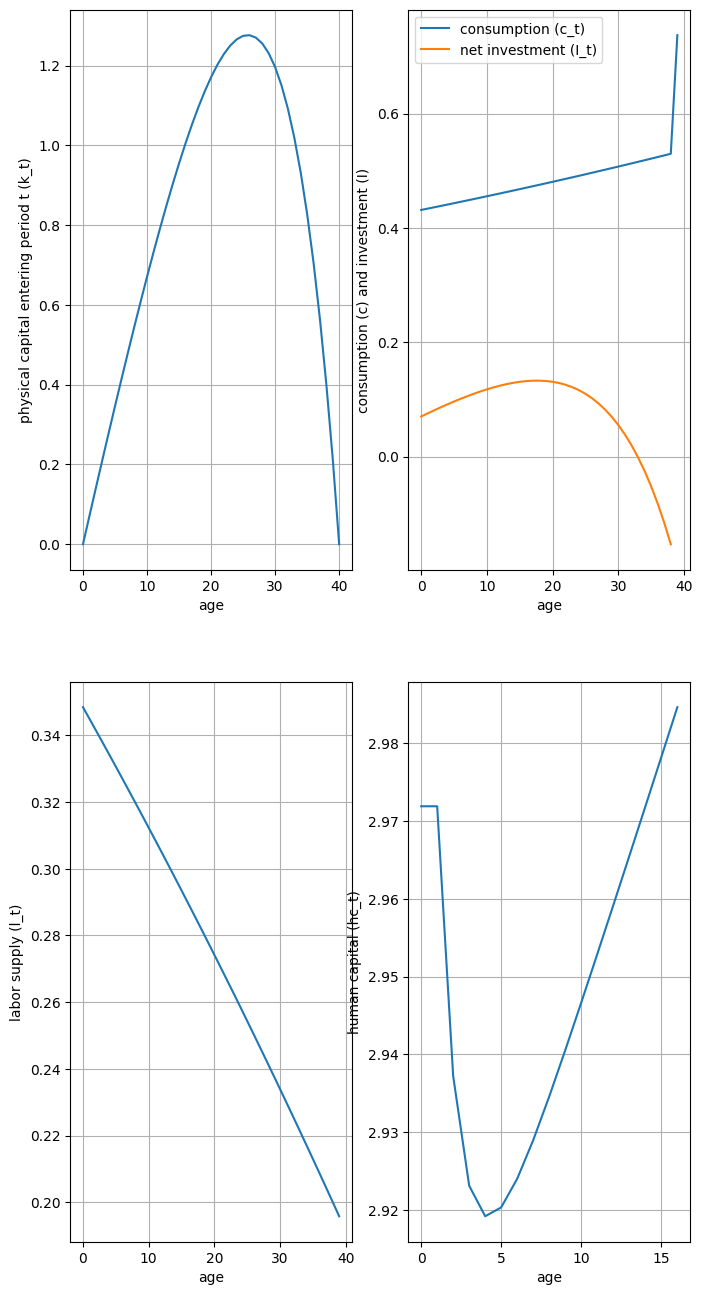

iter: 23; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.754346735811639
ie: 0.04526080414869834
tax_revenue: 0.07808329341064701
grants: 0.052804271506814736
T: 0.04036595662006507
iter: 23; K: 0.83; H: 2.98; L: 0.27; Z: 0.29
iter: 23; Y: 0.75; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.0163168  0.01617584 0.01602646 0.01586825 0.01570076 0.01552356
  0.01533617 0.01513813 0.01492895 0.01470814 0.01447519 0.01422957
  0.01397078 0.01369825 0.01341144 0.01310981 0.0127928  0.01245983
  0.01211037 0.01174381 0.01135961 0.01095719 0.01053599 0.01009544
  0.009635   0.00915411 0.00865223 0.00812885 0.00758343 0.00701549
  0.00642453 0.00581009 0.00517172 0.00450899 0.00382149 0.00310884
  0.00237069 0.00160669 0.00081656 0.        ]
 [0.01631915 0.01617817 0.01602877 0.01587054 0.01570303 0.0155258
  0.01533839 0.01514031 0.0149311  0.01471026 0.01447728 0.01423163
  0.01397279 0.01370022 0.01341338 0.0131117  0.01279464 0.01246163
  0.01211211 0.0117

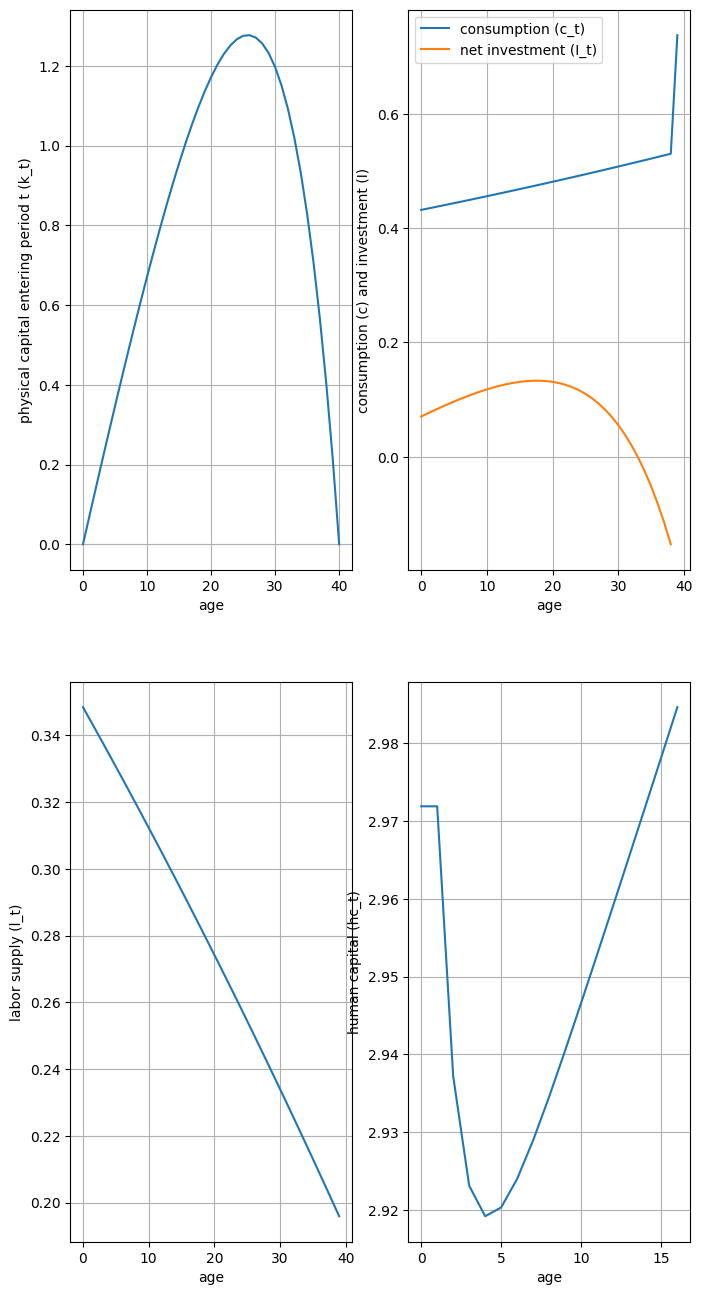

iter: 24; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7555529636157442
ie: 0.04533317781694465
tax_revenue: 0.07820734740518169
grants: 0.0528887074531021
T: 0.04042969922439449
iter: 24; K: 0.83; H: 2.98; L: 0.27; Z: 0.29
iter: 24; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01633187 0.01619075 0.01604121 0.01588283 0.01571516 0.01553777
  0.01535018 0.01515193 0.01494253 0.01472149 0.0144883  0.01424244
  0.01398338 0.01371057 0.01342348 0.01312155 0.01280423 0.01247095
  0.01212114 0.01175423 0.01136966 0.01096686 0.01054526 0.0101043
  0.00964344 0.0091621  0.00865977 0.00813591 0.00759001 0.00702155
  0.00643007 0.00581509 0.00517615 0.00451284 0.00382474 0.00311148
  0.0023727  0.00160805 0.00081725 0.        ]
 [0.01633423 0.01619309 0.01604353 0.01588512 0.01571743 0.01554001
  0.0153524  0.01515411 0.01494469 0.01472362 0.0144904  0.0142445
  0.0139854  0.01371256 0.01342542 0.01312345 0.01280608 0.01247275
  0.01212289 0.011755

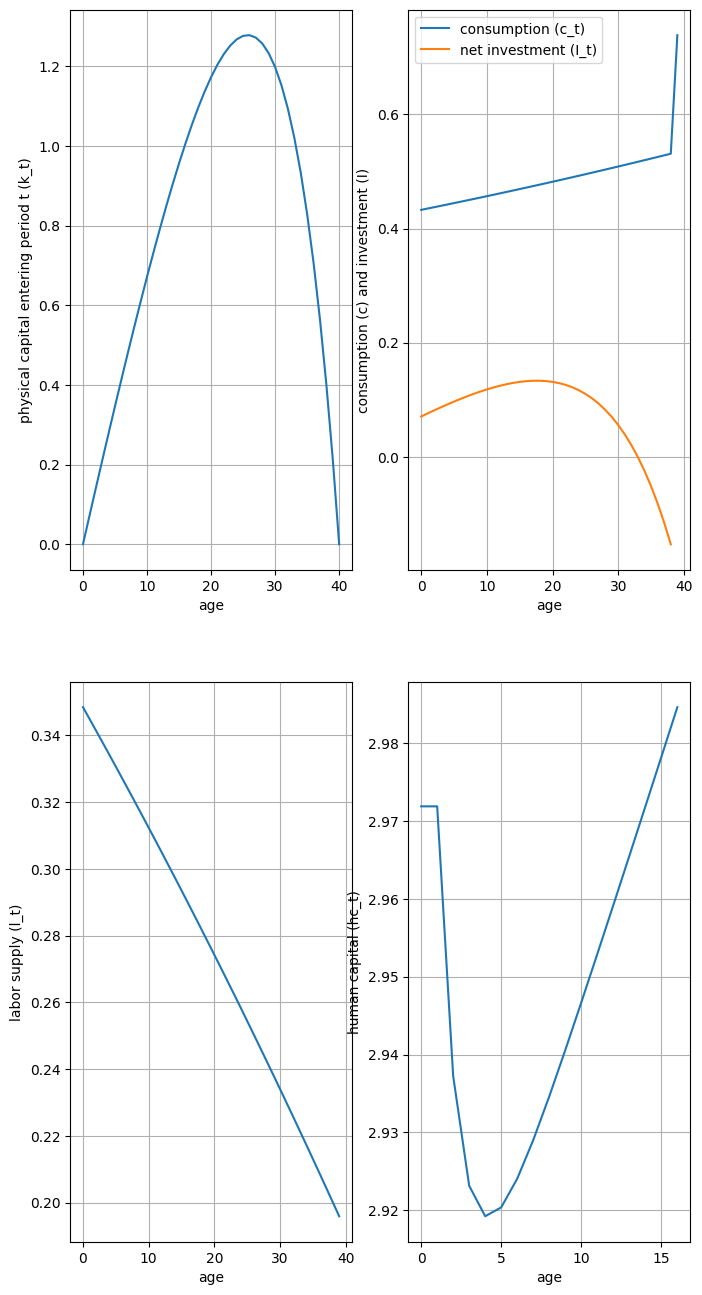

iter: 25; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7566373540000964
ie: 0.04539824124000578
tax_revenue: 0.0783188600141508
grants: 0.05296461478000675
T: 0.04048699231414598
iter: 25; K: 0.83; H: 2.98; L: 0.27; Z: 0.29
iter: 25; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.0163456  0.01620434 0.01605465 0.01589611 0.01572828 0.01555071
  0.01536294 0.0151645  0.01495491 0.01473366 0.01450025 0.01425416
  0.01399486 0.0137218  0.01343445 0.01313225 0.01281464 0.01248106
  0.01213094 0.01176372 0.01137882 0.01097567 0.01055371 0.01011238
  0.00965112 0.00916939 0.00866663 0.00814234 0.00759599 0.00702707
  0.00643511 0.00581963 0.00518019 0.00451635 0.00382771 0.00311389
  0.00237453 0.00160929 0.00081787 0.        ]
 [0.01634796 0.01620668 0.01605697 0.01589841 0.01573055 0.01555296
  0.01536516 0.01516669 0.01495707 0.01473578 0.01450234 0.01425622
  0.01399688 0.01372379 0.01343639 0.01313415 0.01281649 0.01248286
  0.0121327  0.0117

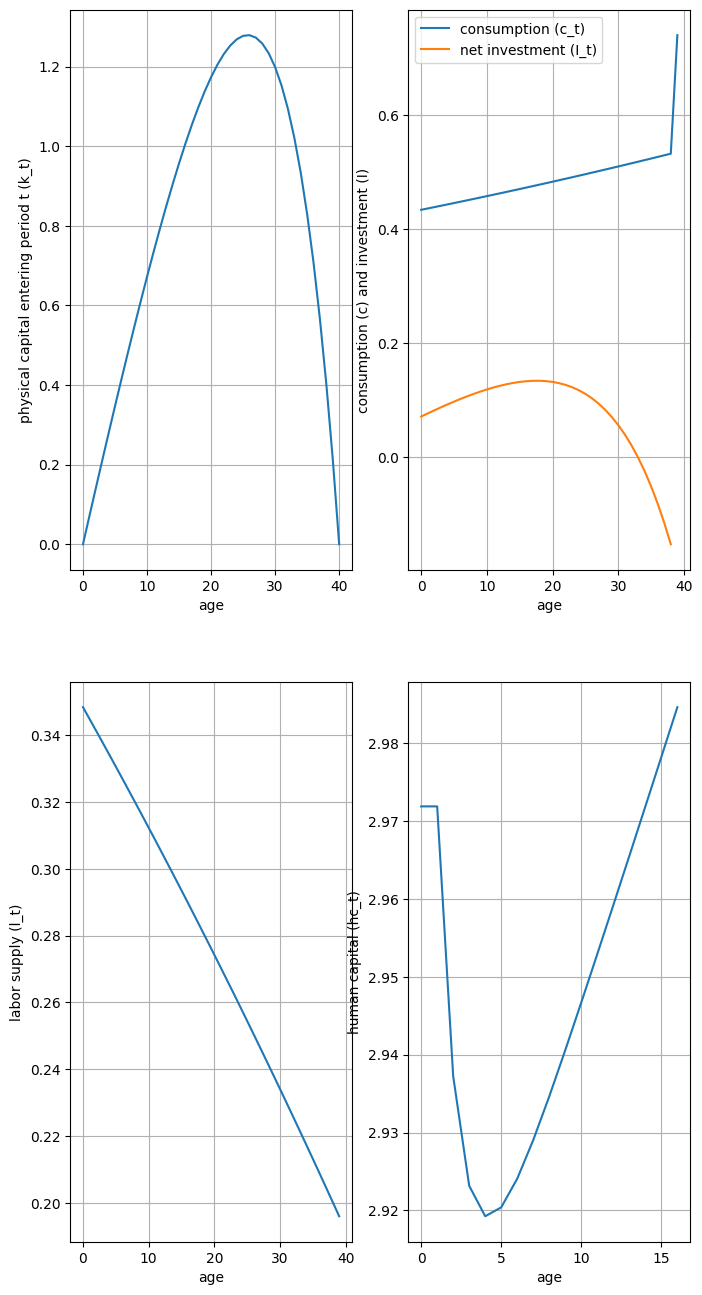

iter: 26; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7576139267900973
ie: 0.045456835607405835
tax_revenue: 0.07841927667778031
grants: 0.05303297487530682
T: 0.040538580338275454
iter: 26; K: 0.83; H: 2.98; L: 0.27; Z: 0.30
iter: 26; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.0163581  0.01621671 0.01606689 0.01590821 0.01574023 0.0155625
  0.01537457 0.01517596 0.01496618 0.01474474 0.01451113 0.01426484
  0.01400531 0.01373204 0.01344444 0.013142   0.01282413 0.01249028
  0.01213989 0.01177236 0.01138716 0.01098369 0.01056141 0.01011974
  0.00965812 0.00917602 0.00867289 0.0081482  0.00760144 0.0070321
  0.00643971 0.00582378 0.00518387 0.00451955 0.00383041 0.00311608
  0.0023762  0.00161041 0.00081844 0.        ]
 [0.01636046 0.01621906 0.01606921 0.0159105  0.0157425  0.01556475
  0.01537679 0.01517815 0.01496834 0.01474687 0.01451323 0.0142669
  0.01400734 0.01373402 0.01344639 0.01314389 0.01282598 0.01249209
  0.01214163 0.0117

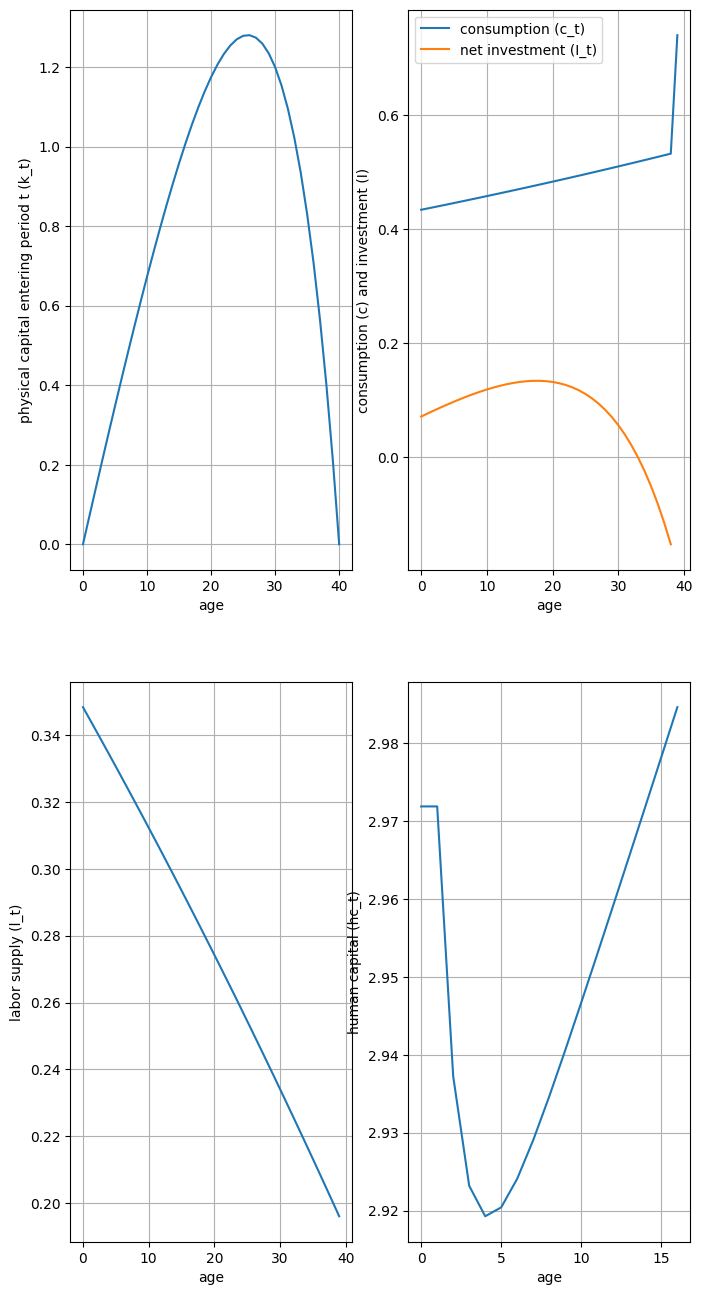

iter: 27; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7584947924713825
ie: 0.04550968754828295
tax_revenue: 0.07850984544724433
grants: 0.05309463547299678
T: 0.04058510582367524
iter: 27; K: 0.83; H: 2.98; L: 0.27; Z: 0.30
iter: 27; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.0163695  0.01622799 0.01607804 0.01591923 0.01575112 0.01557325
  0.01538517 0.01518639 0.01497645 0.01475484 0.01452105 0.01427457
  0.01401484 0.01374135 0.01345355 0.01315088 0.01283278 0.01249868
  0.01214803 0.01178024 0.01139476 0.010991   0.01056842 0.01012644
  0.0096645  0.00918207 0.00867859 0.00815354 0.00760641 0.00703669
  0.00644389 0.00582755 0.00518722 0.00452246 0.00383287 0.00311808
  0.00237772 0.00161144 0.00081897 0.        ]
 [0.01637186 0.01623034 0.01608037 0.01592153 0.01575339 0.0155755
  0.01538739 0.01518859 0.01497861 0.01475697 0.01452315 0.01427663
  0.01401688 0.01374334 0.0134555  0.01315278 0.01283463 0.01250049
  0.01214978 0.0117

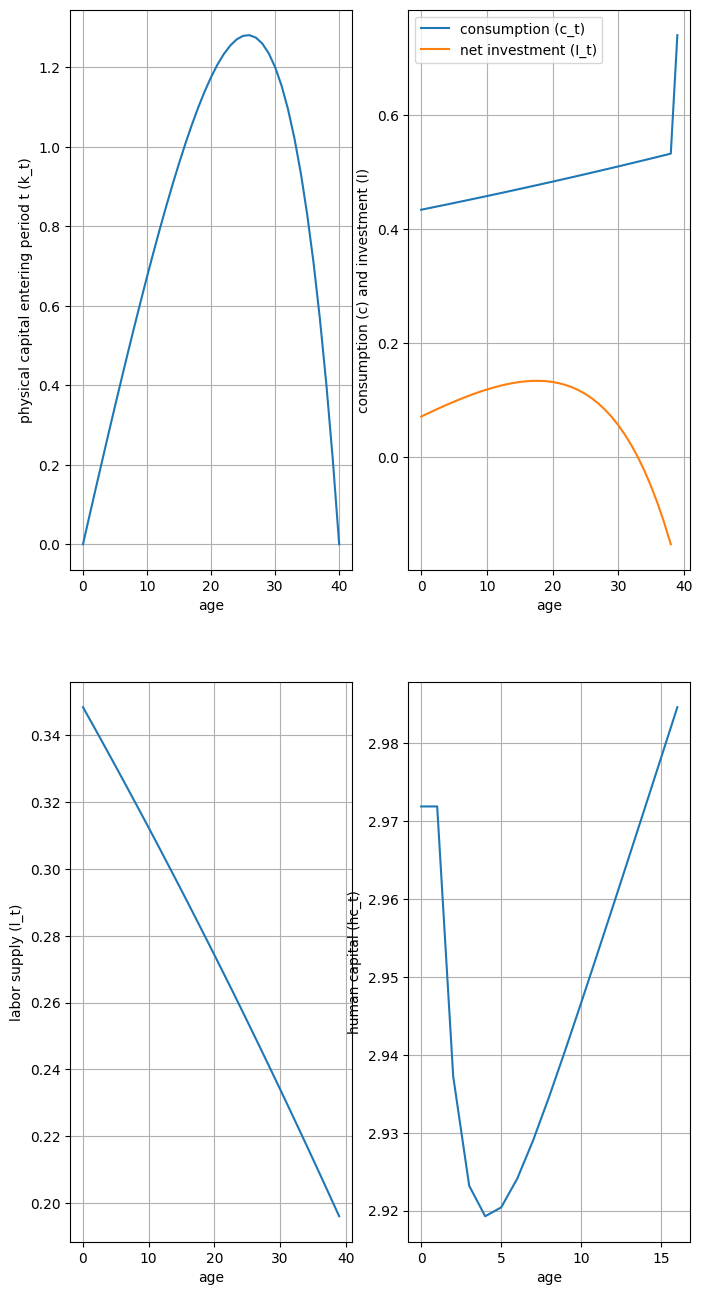

iter: 28; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.759290460814538
ie: 0.04555742764887228
tax_revenue: 0.07859164879947422
grants: 0.053150332257017666
T: 0.04062712575874732
iter: 28; K: 0.83; H: 2.98; L: 0.27; Z: 0.30
iter: 28; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01637988 0.01623827 0.01608821 0.01592928 0.01576105 0.01558304
  0.01539482 0.01519591 0.01498582 0.01476405 0.01453009 0.01428344
  0.01402354 0.01374986 0.01346185 0.01315897 0.01284065 0.01250634
  0.01215545 0.01178742 0.01140169 0.01099767 0.01057481 0.01013254
  0.00967032 0.00918758 0.00868378 0.00815841 0.00761094 0.00704086
  0.00644771 0.00583099 0.00519027 0.00452512 0.00383512 0.0031199
  0.0023791  0.00161238 0.00081944 0.        ]
 [0.01638225 0.01624062 0.01609054 0.01593158 0.01576332 0.0155853
  0.01539705 0.0151981  0.01498798 0.01476617 0.01453219 0.01428549
  0.01402556 0.01375184 0.0134638  0.01316087 0.01284251 0.01250815
  0.01215721 0.01178

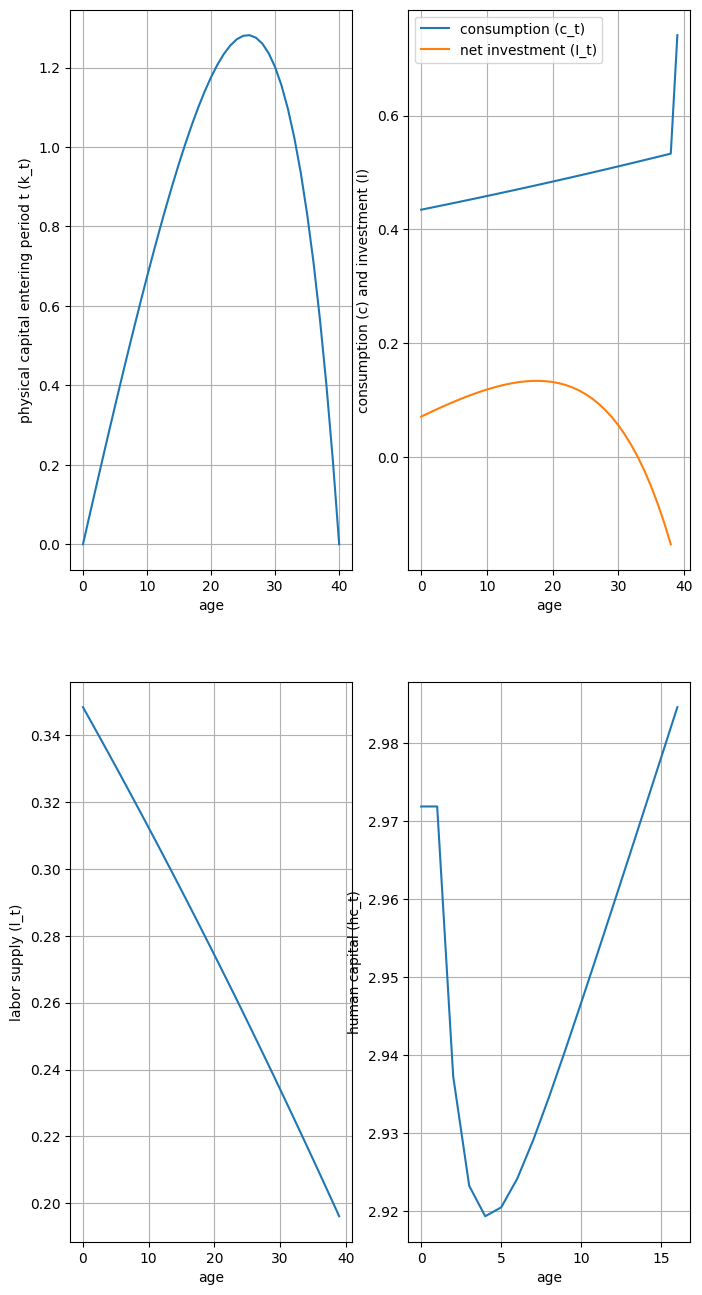

iter: 29; K change: 0.00; H change: 0.00; L change: 0.00; Z change: 0.01
y: 0.7600100860953976
ie: 0.045600605165723854
tax_revenue: 0.07866562949731017
grants: 0.053200706026677834
T: 0.040665125192540286
iter: 29; K: 0.84; H: 2.98; L: 0.27; Z: 0.30
iter: 29; Y: 0.76; tau: 0.15; T: 0.04

Full output of k1_optimal_array[0]:
[[0.01638935 0.01624764 0.01609748 0.01593844 0.01577008 0.01559197
  0.01540362 0.01520458 0.01499435 0.01477244 0.01453833 0.01429151
  0.01403145 0.0137576  0.01346942 0.01316635 0.01284784 0.01251332
  0.01216222 0.01179397 0.011408   0.01100375 0.01058064 0.01013812
  0.00967562 0.0091926  0.00868851 0.00816284 0.00761506 0.00704467
  0.00645118 0.00583413 0.00519306 0.00452754 0.00383717 0.00312156
  0.00238036 0.00161323 0.00081987 0.        ]
 [0.01639172 0.01624998 0.0160998  0.01594074 0.01577236 0.01559422
  0.01540585 0.01520677 0.01499651 0.01477457 0.01454043 0.01429358
  0.01403348 0.01375959 0.01347136 0.01316825 0.01284969 0.01251512
  0.01216397 0.

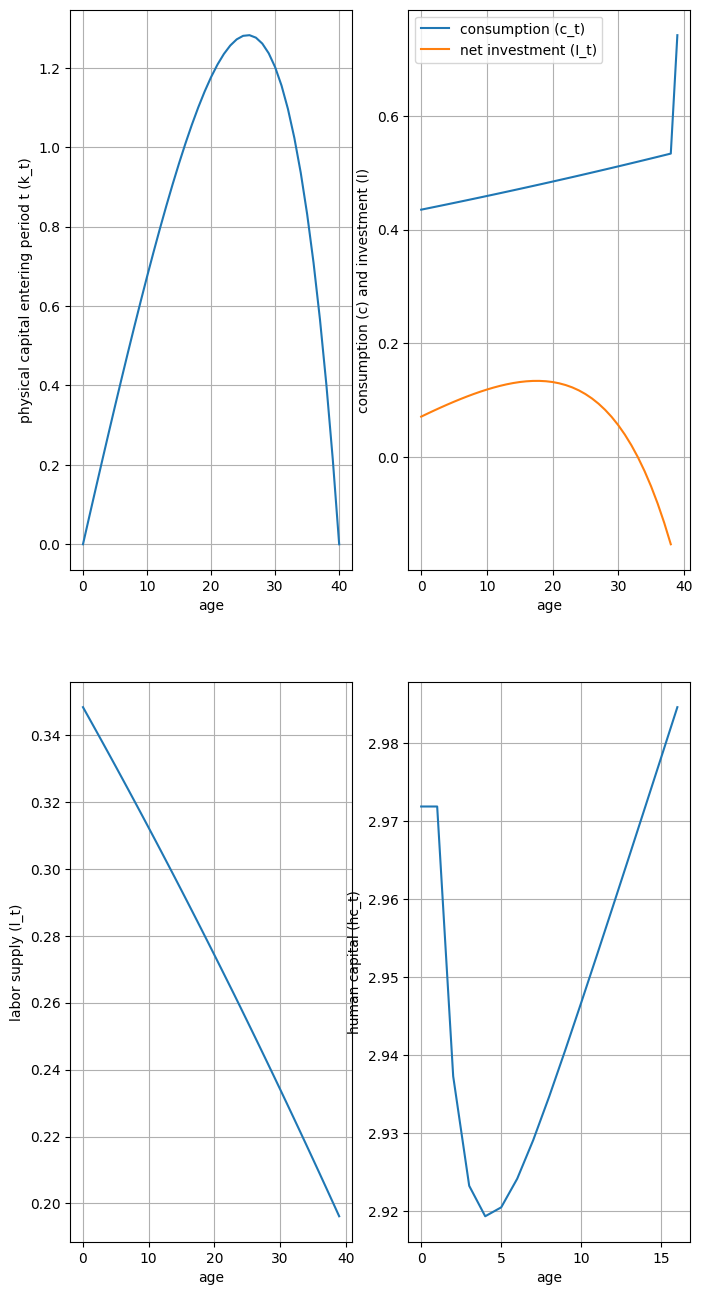

In [14]:
hc_min = np.ones(child_periods+1)
hc_max = np.ones(child_periods+1)
e_mean = 0.02 * np.ones(child_periods+1)
e_minprop = 0.001
e_maxprop = 1
deggridh = 2.5
deggridk = 3.0

hc_grid = np.zeros((nh, child_periods + 1))


iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

omega = 0.1


v_optimal_array = np.zeros((na, nh, periods + 1)) #vw initialize the agents' value function array
k1_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal capital array
c_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal consumption array
l_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal labor array
h_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal child human capital array
hc_optimal_array = np.zeros((na, nh, child_periods)) #initialize the optimal child human capital array


max_iters_ss = max_iters
# tolerance_ss = 0.01

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance: #TODO fix k tolerance
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar) #can you solve for H in terms of K?
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y
  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y
  I_e_mean = (0.03*Y)

  print(f"y: {Y}")
  print(f"ie: {Ie}")

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz - Ie


  #SHOULD THIS BE HERE OR END?
  print(f"T: {T}")
  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old






  #FIRST ITER ONLY
  if iteration == 0:
    #minimun hc vectors
    for i in range(1, child_periods + 1): 
      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

    #maximun hc vectors
    for i in range(1, child_periods + 1):
      hc_max[i] = human_capital_formation(h_c = hc_max[i-1], e_p = e_mean[i]*e_maxprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)



    # print("hc_min:", hc_min)
    # print("hc_max:", hc_max)

    # hc_minval = min(hc_min[1:])
    # hc_maxval = max(hc_max[1:])


    #see 402-404 #UNCOMMENT LATER
    # dampssbfinal = speedbeta
    # dampssw1final = dampssw
    # dampssw2final = dampssw

  # h_grid = loggrid(hc_minval[child_periods-1], min(h_max, hc_maxval[child_periods-1]), nh, deggridh)
  # h_grid = loggrid(hc_min[child_periods], min(h_max, hc_max[child_periods]), nh, deggridh)
  h_grid = loggrid(hc_min[child_periods], max(h_max, hc_max[child_periods]), nh, deggridh)

    # print(f"h_grid: {h_grid}")
  k_grid = loggrid(k_min, k_max, na, deggridk)
    # print(f"h_grid: {k_grid}")


  for i in range(child_periods + 1):
      hc_grid[:,i] = loggrid(hc_min[i], hc_max[i], nh, deggridh)
      # print(f"period {i}")
      # print(hc_grid[:,i])


  invTa = spbas(na - 2, k_grid)
    # print(invTa)

  invTh = spbas(nh - 2, h_grid)

  for i in range(child_periods):
      invThcall = np.ones((nh - 2, nh -2, child_periods))
      z = spbas(nh - 2, hc_grid[:,i])
      # print(z)
      invThcall[:,:,i] = z

  # print(invTa)
  # print(invThcall[:,:,2])
    # break #427
    # compute last period value function st eq. 15 
    # FIX THIS LATER


  for ik in range(na):
    for ih in range(nh):
      l_optimal_array[ik, ih, periods - 1] = labor_foc(k = 0, k_prev = k_grid[ik], h = h_grid[ih], w = w, r = r, tau = tau, T = T) 
      final_period_assets = (1-tau)*w*h_grid[ih]*l_optimal_array[ik, ih, periods - 1] + (1+r)*k_grid[ik] - tau*r*max(k_grid[ik], 0) + T
      v_optimal_array[ik, ih, periods - 1] = utility(final_period_assets, l_optimal_array[ik, ih, periods - 1])
      c_optimal_array[ik, ih, periods - 1] = final_period_assets
      # h_optimal_array[ik, ih, periods - 1] = h
      k1_optimal_array[ik, ih, periods - 1] = 0

    #looking at j = 8
  # for ik in range(na):
  #   for ih in range(nh):

    



  # print(f"T: {T}")
  # print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  # print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  # K_old = K_bar
  # H_old = H_bar
  # L_old = L_bar
  # Z_old = Z_bar
  # state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  # state_var_iter_array[iteration, 1] = H_old
  # state_var_iter_array[iteration, 2] = L_old
  # state_var_iter_array[iteration, 3] = Z_old


  


  # #compute last period value function st eq. 15
  # for i in range(na):
  #   l_optimal_array[i, periods - 1] = labor_foc(k = 0, k_prev = k_grid[i], h = h, w = w, r = r, tau = tau, T = T) #ADDednfoc
  #   final_period_assets = (1-tau)*w*h*l_optimal_array[i, periods - 1] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
  #   value_array[i, periods - 1] = utility(final_period_assets, l_optimal_array[i, periods - 1])
  #   c_optimal_array[i, periods - 1] = final_period_assets
  #   h_optimal_array[i, periods - 1] = h
  #   k_optimal_array[i, periods - 1] = 0


  #compute policy function
  for i in range(periods-1, 0, -1): #loop backwards from age 60 to 0
    
    for ih in range(nh):
      vr_polate = interpolate.interp1d(k_grid, v_optimal_array[:,ih,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
      h0 = h_grid[ih]
      m0 = 0

      for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
        # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

        k0 = k_grid[ik]

        ax = 0
        bx = -1
        cx = -2
        v0 = neg
        m = max(-1, m0-2)

        while (ax > bx or bx > cx):
          m += 1
          v1 = value_function(vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)

          if v1 > v0:
            if m == 0:
              ax = k_grid[m]
              bx = k_grid[m]

            else:
              bx = k_grid[m]
              ax = k_grid[m-1]

            v0 = v1
            m0 = m

          else:
            cx = k_grid[m]

          if m==na-1:
            ax = k_grid[m-1]
            bx = k_grid[m] 
            cx = k_grid[m] 
          

        if ax==bx:  # corner solution: a'=0?
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = ax, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1]=0
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, ax, k_eps, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
                  
        elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
            # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1] = k_grid[na-1]
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
              #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
              k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()     
          
        else:
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
            #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
            k1_optimal_array[ik,ih, i-1] = Search(vr_polate, value_function, ax, bx, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
            
              

        k1 = k1_optimal_array[ik, ih, i-1]
        v_optimal_array[ik, ih, i-1] = value_function(vr_polate, k1_optimal_array[ik, ih, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)
      # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
      # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
      # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")



  
  # Display the full arrays without truncation
  np.set_printoptions(threshold=np.inf)
  print("\nFull output of k1_optimal_array[0]:")
  print(k1_optimal_array[0])
  print("\nFull output of k1_optimal_array[10]:")
  print(k1_optimal_array[10])
  # Reset print options to default
  np.set_printoptions(threshold=1000)

  iteration_ss = -1
  diff_ss = 99
  h0sim = 1
  max_iters_ss = 30
  h = h0sim
  tolerance_ss = 0.005

  # k_gen = np.zeros(periods + 1)
  # l_gen = np.zeros(periods)
  # c_gen = np.zeros(periods)
  # hc_gen = np.zeros(child_periods + 1)
  # i_gen = np.zeros(periods)

  while iteration_ss < max_iters_ss - 1 and diff_ss > tolerance_ss:
    iteration_ss += 1
    
    k_gen = np.zeros(periods + 1)
    l_gen = np.zeros(periods)
    c_gen = np.zeros(periods)
    hc_gen = np.zeros(child_periods + 1)
    i_gen = np.zeros(periods)


    k_gen[0] = k_start
    hc_gen[0] = h

    for q in range(periods):
      bi_polate = interpolate.RegularGridInterpolator((k_grid, h_grid), k1_optimal_array[:,:,q], method='linear', bounds_error=False, fill_value=None) #bilinear interpolator using k_grid and h_grid

      if q < periods - 1:
        k_gen[q+1] = float(bi_polate(np.array([[k_gen[q], h]]))) #right index?
      else:
        k_gen[q+1] =0
      
      
      l_gen[q] = labor_foc(k = k_gen[q+1], k_prev = k_gen[q], h = h, w = w, r = r, tau = tau, T = T)
      c_gen[q] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=h, l=l_gen[q], w=w, r=r, tau=tau, T=T)
      i_gen[q] = -c_gen[q] + (1-tau)*w*h*l_gen[q] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T


      #child concieved period 0 and born period 1
      if q == 0:
        hc_gen[1] = hc_gen[0]

      if q < child_periods and q > 0:
        #could have phi and everything vary here

        log_h = np.log(h) + 1
        e_p = ((omega * log_h) * (1-l_gen[q])) / (1 + omega * log_h)
        hc_gen[q+1] = human_capital_formation(h_c = hc_gen[q], e_p = e_p, I_e = Ie, e_mean = e_mean[q], I_e_mean = I_e_mean)
        print(f"age: {q}, ep: {e_p}, hc: {hc_gen[q+1]}")

    print(f"Ie: {Ie}")
    final_period_assets = (1-tau)*w*h*l_gen[periods-1] + (1+r)*k_gen[periods-2] - tau*r*max(k_gen[periods-2], 0) + T
    c_gen[periods-1] = final_period_assets

    # print(hc_gen)
    diff_ss = abs((h - hc_gen[child_periods])/h)
    print(f"diff_ss: {diff_ss}, h: {h}, hc_gen[child_periods]: {hc_gen[child_periods]}")
    h = hc_gen[child_periods] #check to see if right

    #could shock h each period 

    #add distance h and iter increment


  K_new = np.mean(k_gen[:periods-1])
  L_new = np.mean(l_gen)
  H_new = h

  K_bar = phi*K_old + (1-phi)*K_new
  H_bar = phi*H_old + (1-phi)*H_new
  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz
  L_bar = phi*L_old + (1-phi)*L_new




  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))


  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  axes[0, 0].set_xlabel('age')
  axes[0, 0].set_ylabel('physical capital entering period t (k_t)')
  axes[0, 0].plot(k_gen)
  axes[0, 0].grid(True)

  axes[0, 1].set_xlabel('age')
  axes[0, 1].set_ylabel('consumption (c) and investment (I)')
  axes[0, 1].plot(c_gen, label='consumption (c_t)')
  axes[0, 1].plot(i_gen[:-1], label='net investment (I_t)')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  axes[1, 0].set_xlabel('age')
  axes[1, 0].set_ylabel('labor supply (l_t)')
  axes[1, 0].plot(l_gen)
  axes[1, 0].grid(True)

  axes[1, 1].set_xlabel('age')
  axes[1, 1].set_ylabel('human capital (hc_t)')
  axes[1, 1].plot(hc_gen)
  axes[1, 1].grid(True)


  
  plt.show()     


    #update H, L


aggregates

In [15]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")


Aggregate Factors of Production:
Y: 0.7600
Z: 0.3015
K: 0.8357
H: 2.9831
L: 0.2748

Rates:
Interest rate (r): 0.1092
Return on capital (r^k): 0.2092
